In [1]:
%cd /home/hotson/kaggle_work/csiro-biomass/scripts

/home/hotson/kaggle_work/csiro-biomass/scripts


# Modules

In [74]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm

from warnings import filterwarnings
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.base import clone
import joblib
from pathlib import Path
import json

filterwarnings("ignore")

# Loading cached embeddings

In [4]:
embs = np.load("/home/hotson/kaggle_work/csiro-biomass/outputs_classical/cache_embeddings/train_vit_huge_plus_patch16_dinov3.lvd1689m_sz512.npy")
embs.shape

(357, 1280)

In [7]:
train_df = pd.read_csv("/home/hotson/kaggle_work/csiro-biomass/dataset/train_df.csv")
print(train_df.shape)
train_df.head()

(357, 14)


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g,State_code,Species_code
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750,1,11
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000,0,3
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500,3,12
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376,1,10
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605,1,10


# Selecting best parameters for PCA

In [10]:
Xs = StandardScaler().fit_transform(embs)

pca_full = PCA(svd_solver="randomized", random_state=42)
pca_full.fit(Xs)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)

for thr in [0.80, 0.85, 0.90, 0.95, 0.97, 0.99]:
    k = int(np.searchsorted(cum_var, thr) + 1)
    print(f"{thr*100:.0f}% variance -> {k} components")


80% variance -> 12 components
85% variance -> 17 components
90% variance -> 27 components
95% variance -> 54 components
97% variance -> 82 components
99% variance -> 156 components


In [21]:
def weighted_r2_score(y_true: np.ndarray, y_pred: np.ndarray, target_names: list[str]) -> float:
    """
    Global weighted R^2 over all (sample, target) pairs:
      ybar_w = sum(w_i * y_i) / sum(w_i)
      R2_w = 1 - sum(w_i*(y_i - yhat_i)^2) / sum(w_i*(y_i - ybar_w)^2)

    y_true, y_pred: shape (N, T)
    target_names: length T, order must match columns in y_true/y_pred
    """
    TARGET_WEIGHTS = {
        "Dry_Green_g": 0.1,
        "Dry_Dead_g": 0.1,
        "Dry_Clover_g": 0.1,
        "GDM_g": 0.2,
        "Dry_Total_g": 0.5,
    }

    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)

    # weights per target -> expanded to (N, T)
    w_t = np.array([TARGET_WEIGHTS[t] for t in target_names], dtype=np.float64)  # (T,)
    w = np.broadcast_to(w_t, y_true.shape)  # (N, T)

    # flatten everything into one long vector (global)
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    ww = w.reshape(-1)

    w_sum = ww.sum()
    if w_sum <= 0:
        return 0.0

    y_wmean = (ww * yt).sum() / w_sum
    ss_res = (ww * (yt - yp) ** 2).sum()
    ss_tot = (ww * (yt - y_wmean) ** 2).sum()

    if ss_tot <= 1e-12:
        return 0.0

    return float(1.0 - ss_res / ss_tot)

# Running for other models

In [15]:
# targets
target_names = ["Dry_Green_g", "Dry_Clover_g", "Dry_Dead_g", "GDM_g", "Dry_Total_g"]
Y = train_df[target_names].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# choose same PCA grid you want to compare
pca_grid = [16, 24, 32, 48, 64, 128, 156, 256]


def pca_cv_sweep(model_name: str, make_pipeline_fn, X, Y, pca_grid, kf, target_names):
    rows = []
    for k in tqdm(pca_grid, desc=f"PCA sweep: {model_name}"):
        fold_scores = []
        for tr, va in kf.split(X):
            Xtr, Xva = X[tr], X[va]
            Ytr, Yva = Y[tr], Y[va]

            pipe = make_pipeline_fn(k)
            pipe.fit(Xtr, Ytr)
            pred = pipe.predict(Xva)

            sc = weighted_r2_score(Yva, pred, target_names)
            fold_scores.append(sc)

        rows.append({
            "model": model_name,
            "pca_components": k,
            "mean_weighted_r2": float(np.mean(fold_scores)),
            "std_weighted_r2": float(np.std(fold_scores)),
            "fold_scores": fold_scores,
        })
        print(f"{model_name} | PCA={k:>3} | mean={np.mean(fold_scores):.5f} | std={np.std(fold_scores):.5f} | folds={fold_scores}")

    return pd.DataFrame(rows).sort_values("mean_weighted_r2", ascending=False).reset_index(drop=True)


### LightGBM

In [22]:
def make_lgbm_pipe(n_components: int):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components, svd_solver="randomized", random_state=42)),
        ("model", MultiOutputRegressor(
            LGBMRegressor(
                objective="regression",
                n_estimators=2500,
                learning_rate=0.03,
                num_leaves=31,
                min_child_samples=5,
                feature_fraction=0.8,
                bagging_fraction=0.8,
                bagging_freq=1,
                reg_lambda=1.0,
                reg_alpha=0.0,
                n_jobs=-1,
                random_state=42,
                verbosity=-1,   # stops the spam
            )
        ))
    ])

lgbm_pca_results = pca_cv_sweep("lgbm", make_lgbm_pipe, embs, Y, pca_grid, kf, target_names)
lgbm_pca_results

PCA sweep: lgbm:  12%|█▎        | 1/8 [01:24<09:49, 84.16s/it]

lgbm | PCA= 16 | mean=0.73402 | std=0.04162 | folds=[0.6958640488412471, 0.7692543159606953, 0.7693599477312872, 0.7635715496206535, 0.6720277552864686]


PCA sweep: lgbm:  25%|██▌       | 2/8 [03:13<09:54, 99.16s/it]

lgbm | PCA= 24 | mean=0.74247 | std=0.04583 | folds=[0.6746845485262214, 0.7909645782370747, 0.7538395805139055, 0.7876211619254774, 0.7052399452186611]


PCA sweep: lgbm:  38%|███▊      | 3/8 [04:35<07:36, 91.34s/it]

lgbm | PCA= 32 | mean=0.73045 | std=0.04589 | folds=[0.6774377450348605, 0.7755901672678986, 0.7505562739398048, 0.7753275195355911, 0.673316562455579]


PCA sweep: lgbm:  50%|█████     | 4/8 [06:16<06:19, 94.91s/it]

lgbm | PCA= 48 | mean=0.74139 | std=0.03726 | folds=[0.6906409961491631, 0.7668323798656601, 0.7627755804789497, 0.7836664523369412, 0.7030136504468014]


PCA sweep: lgbm:  62%|██████▎   | 5/8 [09:02<06:01, 120.65s/it]

lgbm | PCA= 64 | mean=0.72849 | std=0.04331 | folds=[0.6857579425924654, 0.7704403202898873, 0.7358542267670529, 0.7786570030248403, 0.6717404564383079]


PCA sweep: lgbm:  75%|███████▌  | 6/8 [11:01<04:00, 120.14s/it]

lgbm | PCA=128 | mean=0.70418 | std=0.04202 | folds=[0.6753677694908476, 0.7417259401912668, 0.7129525614745438, 0.7518025373463703, 0.6390338793467859]


PCA sweep: lgbm:  88%|████████▊ | 7/8 [12:57<01:58, 118.68s/it]

lgbm | PCA=156 | mean=0.69554 | std=0.04860 | folds=[0.643627909400521, 0.7367688326717072, 0.7183538514810603, 0.7478622247581717, 0.6310725466361072]


PCA sweep: lgbm: 100%|██████████| 8/8 [15:00<00:00, 112.55s/it]

lgbm | PCA=256 | mean=0.68070 | std=0.04407 | folds=[0.6310768347339466, 0.7235567042664843, 0.6978927530588485, 0.7257759406360424, 0.625178619915037]


,model,pca_components,mean_weighted_r2,std_weighted_r2,fold_scores
0,lgbm,24,0.742470,0.045827,"[0.6746845485262214, 0.7909645782370747, 0.753..."
1,lgbm,48,0.741386,0.037256,"[0.6906409961491631, 0.7668323798656601, 0.762..."
2,lgbm,16,0.734016,0.041623,"[0.6958640488412471, 0.7692543159606953, 0.769..."
3,lgbm,32,0.730446,0.045892,"[0.6774377450348605, 0.7755901672678986, 0.750..."
4,lgbm,64,0.728490,0.043307,"[0.6857579425924654, 0.7704403202898873, 0.735..."
5,lgbm,128,0.704177,0.042021,"[0.6753677694908476, 0.7417259401912668, 0.712..."
6,lgbm,156,0.695537,0.048598,"[0.643627909400521, 0.7367688326717072, 0.7183..."
7,lgbm,256,0.680696,0.044066,"[0.6310768347339466, 0.7235567042664843, 0.697..."


### XGBoost

In [16]:
# XGB

from xgboost import XGBRegressor

def make_xgb_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", MultiOutputRegressor(
            XGBRegressor(
                n_estimators=3000,
                learning_rate=0.03,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.7,
                min_child_weight=1,
                reg_lambda=1.0,
                reg_alpha=0.0,
                tree_method="hist",     # use "gpu_hist" if you want GPU
                n_jobs=-1,
                random_state=42,
                verbosity=0,
            )
        ))
    ])

xgb_pca_results = pca_cv_sweep("xgb", make_xgb_pipe, embs, Y, pca_grid, kf, target_names)
xgb_pca_results


PCA sweep: xgb:  12%|█▎        | 1/8 [00:34<04:03, 34.85s/it]

xgb | PCA= 16 | mean=0.73970 | std=0.05282 | folds=[0.689452437797933, 0.7933157122490699, 0.7749705425725824, 0.7776500499502851, 0.6631126199880453]


PCA sweep: xgb:  25%|██▌       | 2/8 [01:11<03:34, 35.72s/it]

xgb | PCA= 24 | mean=0.74136 | std=0.04797 | folds=[0.6843250235156125, 0.8079220573187221, 0.755509129329825, 0.7704004413871799, 0.6886617885615429]


PCA sweep: xgb:  38%|███▊      | 3/8 [01:50<03:05, 37.18s/it]

xgb | PCA= 32 | mean=0.74434 | std=0.04186 | folds=[0.6961688637932896, 0.8005537967114922, 0.7590542021482052, 0.7704026838593799, 0.6954998506746187]


PCA sweep: xgb:  50%|█████     | 4/8 [02:34<02:40, 40.18s/it]

xgb | PCA= 48 | mean=0.74324 | std=0.03963 | folds=[0.7005465213728705, 0.7851268189884606, 0.764924468841222, 0.7751423704817572, 0.6904526148246024]


PCA sweep: xgb:  62%|██████▎   | 5/8 [03:21<02:07, 42.58s/it]

xgb | PCA= 64 | mean=0.73842 | std=0.03967 | folds=[0.6923674521826954, 0.7760762296131767, 0.758229599099224, 0.776715572956495, 0.688713944762293]


PCA sweep: xgb:  75%|███████▌  | 6/8 [04:29<01:42, 51.10s/it]

xgb | PCA=128 | mean=0.71480 | std=0.04630 | folds=[0.6875736845747953, 0.7681238126251216, 0.7194500577347364, 0.7570522328490865, 0.6418162451144463]


PCA sweep: xgb:  88%|████████▊ | 7/8 [05:44<00:59, 59.12s/it]

xgb | PCA=156 | mean=0.70562 | std=0.04394 | folds=[0.6793003920159633, 0.7377331213290079, 0.7298016525052419, 0.7493396935002863, 0.6319034214825325]


PCA sweep: xgb: 100%|██████████| 8/8 [07:32<00:00, 56.51s/it]

xgb | PCA=256 | mean=0.68923 | std=0.04536 | folds=[0.6634243475458512, 0.721626503642077, 0.7239238233855578, 0.7256679225362095, 0.6115134752779969]


,model,pca_components,mean_weighted_r2,std_weighted_r2,fold_scores
0,xgb,32,0.744336,0.041861,"[0.6961688637932896, 0.8005537967114922, 0.759..."
1,xgb,48,0.743239,0.039628,"[0.7005465213728705, 0.7851268189884606, 0.764..."
2,xgb,24,0.741364,0.047967,"[0.6843250235156125, 0.8079220573187221, 0.755..."
3,xgb,16,0.739700,0.052819,"[0.689452437797933, 0.7933157122490699, 0.7749..."
4,xgb,64,0.738421,0.039670,"[0.6923674521826954, 0.7760762296131767, 0.758..."
5,xgb,128,0.714803,0.046299,"[0.6875736845747953, 0.7681238126251216, 0.719..."
6,xgb,156,0.705616,0.043941,"[0.6793003920159633, 0.7377331213290079, 0.729..."
7,xgb,256,0.689231,0.045358,"[0.6634243475458512, 0.721626503642077, 0.7239..."


### ExtraTreesRegressor

In [17]:
from sklearn.ensemble import ExtraTreesRegressor

def make_extratrees_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", ExtraTreesRegressor(
            n_estimators=2000,
            max_features="sqrt",
            random_state=42,
            n_jobs=-1
        ))
    ])

et_pca_results = pca_cv_sweep("extratrees", make_extratrees_pipe, embs, Y, pca_grid, kf, target_names)
et_pca_results


PCA sweep: extratrees:  12%|█▎        | 1/8 [00:05<00:36,  5.20s/it]

extratrees | PCA= 16 | mean=0.70634 | std=0.04564 | folds=[0.6987629008201065, 0.7679588624841249, 0.7020505684582566, 0.7329716030543347, 0.6299530174841912]


PCA sweep: extratrees:  25%|██▌       | 2/8 [00:10<00:33,  5.55s/it]

extratrees | PCA= 24 | mean=0.69110 | std=0.04343 | folds=[0.6862270729610696, 0.7566530329004011, 0.682125247834006, 0.7082433832318573, 0.6222734328488163]


PCA sweep: extratrees:  38%|███▊      | 3/8 [00:16<00:28,  5.69s/it]

extratrees | PCA= 32 | mean=0.67881 | std=0.04502 | folds=[0.6797244232659363, 0.7465167304588902, 0.6685014064270661, 0.6929259902521412, 0.6063918409289427]


PCA sweep: extratrees:  50%|█████     | 4/8 [00:22<00:23,  5.76s/it]

extratrees | PCA= 48 | mean=0.64624 | std=0.03917 | folds=[0.6435696775077369, 0.6961201447871408, 0.6467307441655734, 0.6673329123720156, 0.5774498441132139]


PCA sweep: extratrees:  62%|██████▎   | 5/8 [00:29<00:17,  6.00s/it]

extratrees | PCA= 64 | mean=0.63489 | std=0.03821 | folds=[0.6379619513537074, 0.6866361370778966, 0.6396827236755589, 0.6425957620968201, 0.5675837531916967]


PCA sweep: extratrees:  75%|███████▌  | 6/8 [00:35<00:12,  6.23s/it]

extratrees | PCA=128 | mean=0.54061 | std=0.03634 | folds=[0.5517114484752086, 0.5839132207573551, 0.5365969112574458, 0.5561561610196926, 0.4746722659289846]


PCA sweep: extratrees:  88%|████████▊ | 7/8 [00:42<00:06,  6.48s/it]

extratrees | PCA=156 | mean=0.51397 | std=0.03134 | folds=[0.5150219269191632, 0.5529113512633311, 0.5122097674239932, 0.5313086430579932, 0.4583823077409508]


PCA sweep: extratrees: 100%|██████████| 8/8 [00:50<00:00,  6.31s/it]

extratrees | PCA=256 | mean=0.44504 | std=0.04696 | folds=[0.43326496105079815, 0.5186701159505653, 0.4376535272464085, 0.46213519544867543, 0.3734888494754718]


,model,pca_components,mean_weighted_r2,std_weighted_r2,fold_scores
0,extratrees,16,0.706339,0.045644,"[0.6987629008201065, 0.7679588624841249, 0.702..."
1,extratrees,24,0.691104,0.043434,"[0.6862270729610696, 0.7566530329004011, 0.682..."
2,extratrees,32,0.678812,0.045022,"[0.6797244232659363, 0.7465167304588902, 0.668..."
3,extratrees,48,0.646241,0.039172,"[0.6435696775077369, 0.6961201447871408, 0.646..."
4,extratrees,64,0.634892,0.038209,"[0.6379619513537074, 0.6866361370778966, 0.639..."
5,extratrees,128,0.540610,0.036343,"[0.5517114484752086, 0.5839132207573551, 0.536..."
6,extratrees,156,0.513967,0.031341,"[0.5150219269191632, 0.5529113512633311, 0.512..."
7,extratrees,256,0.445043,0.046960,"[0.43326496105079815, 0.5186701159505653, 0.43..."


### Ridge

In [18]:
from sklearn.linear_model import Ridge

def make_ridge_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", Ridge(alpha=1.0, random_state=42))
    ])

ridge_pca_results = pca_cv_sweep("ridge", make_ridge_pipe, embs, Y, pca_grid, kf, target_names)
ridge_pca_results


PCA sweep: ridge:  12%|█▎        | 1/8 [00:00<00:03,  1.96it/s]

ridge | PCA= 16 | mean=0.70307 | std=0.05478 | folds=[0.7581028257542446, 0.7533989195301035, 0.7156132930811574, 0.6783092809117856, 0.6099431957630115]


PCA sweep: ridge:  25%|██▌       | 2/8 [00:01<00:05,  1.13it/s]

ridge | PCA= 24 | mean=0.72688 | std=0.05470 | folds=[0.7494659329097817, 0.7992443991150248, 0.7467272616699401, 0.7029198043428343, 0.6360658240098237]


PCA sweep: ridge:  38%|███▊      | 3/8 [00:03<00:05,  1.17s/it]

ridge | PCA= 32 | mean=0.73662 | std=0.04806 | folds=[0.7448649674546001, 0.8049758273714868, 0.7533490339497476, 0.7229023331208548, 0.6569848231257704]


PCA sweep: ridge:  50%|█████     | 4/8 [00:04<00:04,  1.24s/it]

ridge | PCA= 48 | mean=0.76497 | std=0.04230 | folds=[0.7745698586879124, 0.8223774668291816, 0.7676320583371197, 0.7696428827197865, 0.6906101355448673]


PCA sweep: ridge:  62%|██████▎   | 5/8 [00:05<00:03,  1.30s/it]

ridge | PCA= 64 | mean=0.76851 | std=0.03012 | folds=[0.7821082795159293, 0.8042675927746467, 0.7680215612164829, 0.77473213334518, 0.7134299838221625]


PCA sweep: ridge:  75%|███████▌  | 6/8 [00:08<00:03,  1.57s/it]

ridge | PCA=128 | mean=0.74556 | std=0.03366 | folds=[0.7237437661357096, 0.7790141242906309, 0.7591758276040749, 0.7751504187672602, 0.6906978389330765]


PCA sweep: ridge:  88%|████████▊ | 7/8 [00:10<00:01,  1.73s/it]

ridge | PCA=156 | mean=0.73220 | std=0.03063 | folds=[0.7015824082987755, 0.7453749648854615, 0.738074860554552, 0.7796821086527124, 0.6962739280518326]


PCA sweep: ridge: 100%|██████████| 8/8 [00:13<00:00,  1.65s/it]

ridge | PCA=256 | mean=0.67965 | std=0.07146 | folds=[0.5497402888638081, 0.7360196293031442, 0.7267877716752931, 0.7309690619025326, 0.6547349383561991]


,model,pca_components,mean_weighted_r2,std_weighted_r2,fold_scores
0,ridge,64,0.768512,0.030121,"[0.7821082795159293, 0.8042675927746467, 0.768..."
1,ridge,48,0.764966,0.042299,"[0.7745698586879124, 0.8223774668291816, 0.767..."
2,ridge,128,0.745556,0.033663,"[0.7237437661357096, 0.7790141242906309, 0.759..."
3,ridge,32,0.736615,0.048063,"[0.7448649674546001, 0.8049758273714868, 0.753..."
4,ridge,156,0.732198,0.030629,"[0.7015824082987755, 0.7453749648854615, 0.738..."
5,ridge,24,0.726885,0.054703,"[0.7494659329097817, 0.7992443991150248, 0.746..."
6,ridge,16,0.703074,0.054781,"[0.7581028257542446, 0.7533989195301035, 0.715..."
7,ridge,256,0.679650,0.071457,"[0.5497402888638081, 0.7360196293031442, 0.726..."


### ElasticNet

In [19]:
from sklearn.linear_model import ElasticNet

def make_enet_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=50000, random_state=42))
    ])

enet_pca_results = pca_cv_sweep("elasticnet", make_enet_pipe, embs, Y, pca_grid, kf, target_names)
enet_pca_results


PCA sweep: elasticnet:  12%|█▎        | 1/8 [00:00<00:02,  2.39it/s]

elasticnet | PCA= 16 | mean=0.70307 | std=0.05479 | folds=[0.7581032262364656, 0.7534060135040895, 0.7156120103792266, 0.6783061181945291, 0.6099300095777491]


PCA sweep: elasticnet:  25%|██▌       | 2/8 [00:01<00:04,  1.37it/s]

elasticnet | PCA= 24 | mean=0.72688 | std=0.05471 | folds=[0.7494404559274016, 0.7992510609714321, 0.7467275571588463, 0.7029190624556676, 0.636049873570237]


PCA sweep: elasticnet:  38%|███▊      | 3/8 [00:02<00:04,  1.02it/s]

elasticnet | PCA= 32 | mean=0.73660 | std=0.04806 | folds=[0.7448272411325609, 0.8049682002107604, 0.7533449142189744, 0.7228960237734159, 0.6569751760268546]


PCA sweep: elasticnet:  50%|█████     | 4/8 [00:03<00:04,  1.11s/it]

elasticnet | PCA= 48 | mean=0.76494 | std=0.04230 | folds=[0.774497987256571, 0.8223598618862881, 0.7675861691114534, 0.7696622657309674, 0.6905976459966713]


PCA sweep: elasticnet:  62%|██████▎   | 5/8 [00:05<00:03,  1.28s/it]

elasticnet | PCA= 64 | mean=0.76846 | std=0.03010 | folds=[0.7820035575044527, 0.804196630031988, 0.7679317295521298, 0.774730502531106, 0.7134240536672158]


PCA sweep: elasticnet:  75%|███████▌  | 6/8 [00:07<00:03,  1.52s/it]

elasticnet | PCA=128 | mean=0.74498 | std=0.03372 | folds=[0.7228193266130433, 0.7783350507737072, 0.7586903761268464, 0.7748656346170527, 0.6902077726760183]


PCA sweep: elasticnet:  88%|████████▊ | 7/8 [00:09<00:01,  1.61s/it]

elasticnet | PCA=156 | mean=0.73111 | std=0.03079 | folds=[0.6998740741695622, 0.7439623739452348, 0.7370329171844303, 0.7790851371230783, 0.695575875416735]


PCA sweep: elasticnet: 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]

elasticnet | PCA=256 | mean=0.67267 | std=0.07482 | folds=[0.5363006690072372, 0.7312811825265696, 0.723336085735439, 0.7250924668241787, 0.6473471721573485]


,model,pca_components,mean_weighted_r2,std_weighted_r2,fold_scores
0,elasticnet,64,0.768457,0.030097,"[0.7820035575044527, 0.804196630031988, 0.7679..."
1,elasticnet,48,0.764941,0.042295,"[0.774497987256571, 0.8223598618862881, 0.7675..."
2,elasticnet,128,0.744984,0.033719,"[0.7228193266130433, 0.7783350507737072, 0.758..."
3,elasticnet,32,0.736602,0.048063,"[0.7448272411325609, 0.8049682002107604, 0.753..."
4,elasticnet,156,0.731106,0.030790,"[0.6998740741695622, 0.7439623739452348, 0.737..."
5,elasticnet,24,0.726878,0.054708,"[0.7494404559274016, 0.7992510609714321, 0.746..."
6,elasticnet,16,0.703071,0.054787,"[0.7581032262364656, 0.7534060135040895, 0.715..."
7,elasticnet,256,0.672672,0.074817,"[0.5363006690072372, 0.7312811825265696, 0.723..."


### Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

def make_linear_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", LinearRegression())
    ])

linear_results = pca_cv_sweep("linear", make_linear_pipe, embs, Y, pca_grid, kf, target_names)

PCA sweep: linear:  12%|█▎        | 1/8 [00:00<00:02,  2.71it/s]

linear | PCA= 16 | mean=0.70307 | std=0.05479 | folds=[0.75810324274735, 0.7534074834871003, 0.7156093981346291, 0.6783045462953892, 0.609925876630645]


PCA sweep: linear:  25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

linear | PCA= 24 | mean=0.72687 | std=0.05471 | folds=[0.7494286229148587, 0.7992522415972341, 0.7467249027461558, 0.7029168327183819, 0.6360455137139112]


PCA sweep: linear:  38%|███▊      | 3/8 [00:02<00:04,  1.00it/s]

linear | PCA= 32 | mean=0.73660 | std=0.04806 | folds=[0.7448100126690863, 0.8049673767455198, 0.7533399511957739, 0.7228933709638258, 0.6569687246045075]


PCA sweep: linear:  50%|█████     | 4/8 [00:04<00:04,  1.15s/it]

linear | PCA= 48 | mean=0.76493 | std=0.04229 | folds=[0.7744727042799592, 0.8223515520497117, 0.7675670375943119, 0.7696644256264329, 0.6905921904377373]


PCA sweep: linear:  62%|██████▎   | 5/8 [00:05<00:04,  1.34s/it]

linear | PCA= 64 | mean=0.76843 | std=0.03009 | folds=[0.781963236616053, 0.8041655296211798, 0.7678909271039196, 0.7747238904639897, 0.7134218385505995]


PCA sweep: linear:  75%|███████▌  | 6/8 [00:07<00:03,  1.61s/it]

linear | PCA=128 | mean=0.74482 | std=0.03375 | folds=[0.7225652974711183, 0.7781838306474929, 0.7585335728123054, 0.7747583930667628, 0.6900398607497928]


PCA sweep: linear:  88%|████████▊ | 7/8 [00:10<00:01,  1.84s/it]

linear | PCA=156 | mean=0.73079 | std=0.03083 | folds=[0.6994021771857812, 0.7435860834119596, 0.7367394988419806, 0.778884037784569, 0.695344674642446]


PCA sweep: linear: 100%|██████████| 8/8 [00:13<00:00,  1.69s/it]

linear | PCA=256 | mean=0.67089 | std=0.07564 | folds=[0.5329724376863858, 0.7301062563469025, 0.7224453420505316, 0.7235326713241141, 0.6453784460033545]


### RandomForest Regression

In [28]:
from sklearn.ensemble import RandomForestRegressor

def make_rf_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", RandomForestRegressor(
            n_estimators=800,
            max_depth=None,
            min_samples_leaf=1,
            n_jobs=-1,
            random_state=42,
        ))
    ])

rf_results = pca_cv_sweep("random_forest", make_rf_pipe, embs, Y, pca_grid, kf, target_names)

PCA sweep: random_forest:  12%|█▎        | 1/8 [00:03<00:24,  3.56s/it]

random_forest | PCA= 16 | mean=0.72419 | std=0.03774 | folds=[0.705610408528851, 0.7546711552592076, 0.7575417853540497, 0.7446477648898697, 0.6584875906075405]


PCA sweep: random_forest:  25%|██▌       | 2/8 [00:07<00:23,  3.86s/it]

random_forest | PCA= 24 | mean=0.72261 | std=0.03410 | folds=[0.6867754517355604, 0.7616446423011295, 0.7409755423627822, 0.746734898766676, 0.6769308297307812]


PCA sweep: random_forest:  38%|███▊      | 3/8 [00:12<00:20,  4.10s/it]

random_forest | PCA= 32 | mean=0.71541 | std=0.03373 | folds=[0.6837511443206848, 0.7614902237806154, 0.7340910350770977, 0.7277097855253629, 0.6699972144464325]


PCA sweep: random_forest:  50%|█████     | 4/8 [00:16<00:17,  4.33s/it]

random_forest | PCA= 48 | mean=0.70975 | std=0.03284 | folds=[0.6800633848245287, 0.7521029027711881, 0.7255658706427546, 0.7276322686155978, 0.6634104976279411]


PCA sweep: random_forest:  62%|██████▎   | 5/8 [00:21<00:13,  4.55s/it]

random_forest | PCA= 64 | mean=0.70192 | std=0.03183 | folds=[0.6709820887088604, 0.7348299350294437, 0.7217806842836052, 0.7256024480561863, 0.6564108328989038]


PCA sweep: random_forest:  75%|███████▌  | 6/8 [00:27<00:10,  5.16s/it]

random_forest | PCA=128 | mean=0.68637 | std=0.03858 | folds=[0.6681650713237468, 0.7345921152506953, 0.6918769732441914, 0.7140187781587086, 0.62319324693098]


PCA sweep: random_forest:  88%|████████▊ | 7/8 [00:34<00:05,  5.54s/it]

random_forest | PCA=156 | mean=0.68145 | std=0.04078 | folds=[0.6666269489316825, 0.7217696497357646, 0.696787238992999, 0.7130027423471726, 0.6090659374196568]


PCA sweep: random_forest: 100%|██████████| 8/8 [00:43<00:00,  5.38s/it]

random_forest | PCA=256 | mean=0.66622 | std=0.04288 | folds=[0.6506267504016908, 0.7139182302291678, 0.6786203655869263, 0.6965456615456693, 0.5913714478794848]


### LassoRegression

In [24]:
from sklearn.linear_model import Lasso

def make_lasso_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", Lasso(alpha=0.001, max_iter=50000, random_state=42))
    ])

lasso_results = pca_cv_sweep("lasso", make_lasso_pipe, embs, Y, pca_grid, kf, target_names)

PCA sweep: lasso:  12%|█▎        | 1/8 [00:00<00:02,  3.13it/s]

lasso | PCA= 16 | mean=0.70307 | std=0.05479 | folds=[0.7581033169851332, 0.7534069436750095, 0.7156135206091738, 0.6783063374765015, 0.6099291483015749]


PCA sweep: lasso:  25%|██▌       | 2/8 [00:01<00:04,  1.31it/s]

lasso | PCA= 24 | mean=0.72688 | std=0.05471 | folds=[0.7494415603733378, 0.7992520501236005, 0.7467296078922883, 0.7029204415080158, 0.6360483915175883]


PCA sweep: lasso:  38%|███▊      | 3/8 [00:02<00:04,  1.01it/s]

lasso | PCA= 32 | mean=0.73660 | std=0.04806 | folds=[0.7448288960943247, 0.8049666656934922, 0.7533470936689339, 0.7228960753330214, 0.6569770195973844]


PCA sweep: lasso:  50%|█████     | 4/8 [00:03<00:04,  1.06s/it]

lasso | PCA= 48 | mean=0.76494 | std=0.04230 | folds=[0.7744955542707977, 0.8223607633576933, 0.7675868154981548, 0.7696662648889279, 0.6905978441233589]


PCA sweep: lasso:  62%|██████▎   | 5/8 [00:05<00:03,  1.22s/it]

lasso | PCA= 64 | mean=0.76846 | std=0.03010 | folds=[0.7820023803240096, 0.8041985698324952, 0.7679349559931158, 0.7747347013030028, 0.713424233476417]


PCA sweep: lasso:  75%|███████▌  | 6/8 [00:07<00:02,  1.45s/it]

lasso | PCA=128 | mean=0.74494 | std=0.03372 | folds=[0.7227346123735736, 0.7782467879230001, 0.7586616995345827, 0.7748593466867929, 0.6901856977707053]


PCA sweep: lasso:  88%|████████▊ | 7/8 [00:09<00:01,  1.74s/it]

lasso | PCA=156 | mean=0.73101 | std=0.03081 | folds=[0.6997148120359509, 0.7438210822057454, 0.7369388296655004, 0.7790535053363266, 0.6955367133885703]


PCA sweep: lasso: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]

lasso | PCA=256 | mean=0.67178 | std=0.07525 | folds=[0.5345677764455743, 0.7306464704274267, 0.7229073410648681, 0.7243564734919464, 0.6464296314564659]


### GradientBoostingRegression

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

def make_gbr_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", MultiOutputRegressor(
            GradientBoostingRegressor(
                n_estimators=800,
                learning_rate=0.05,
                max_depth=3,
                random_state=42,
            )
        ))
    ])

gbr_results = pca_cv_sweep("gbr", make_gbr_pipe, embs, Y, pca_grid, kf, target_names)

PCA sweep: gbr:  12%|█▎        | 1/8 [00:21<02:30, 21.47s/it]

gbr | PCA= 16 | mean=0.71056 | std=0.04012 | folds=[0.6751978236718574, 0.7055770591703385, 0.7747411042179513, 0.7330908177063189, 0.6642159965789594]


PCA sweep: gbr:  25%|██▌       | 2/8 [00:52<02:42, 27.07s/it]

gbr | PCA= 24 | mean=0.72988 | std=0.04129 | folds=[0.6733765750756856, 0.7432046661109657, 0.7750963809031279, 0.7682854225604614, 0.6894423485570713]


PCA sweep: gbr:  38%|███▊      | 3/8 [01:32<02:45, 33.04s/it]

gbr | PCA= 32 | mean=0.73633 | std=0.02713 | folds=[0.7041538765627262, 0.7534419385980878, 0.7719858861206002, 0.7468829043939855, 0.7051779376802509]


PCA sweep: gbr:  50%|█████     | 4/8 [02:30<02:50, 42.66s/it]

gbr | PCA= 48 | mean=0.73810 | std=0.03744 | folds=[0.705965077581407, 0.7455737626700221, 0.778785709440841, 0.7755764788207824, 0.6846085469715855]


PCA sweep: gbr:  62%|██████▎   | 5/8 [03:44<02:42, 54.29s/it]

gbr | PCA= 64 | mean=0.73129 | std=0.03939 | folds=[0.6886699386554072, 0.7452551488724275, 0.7845659156096706, 0.7550782287572873, 0.6828858153773755]


PCA sweep: gbr:  75%|███████▌  | 6/8 [06:08<02:49, 84.54s/it]

gbr | PCA=128 | mean=0.71890 | std=0.03641 | folds=[0.7185952988608076, 0.7309123333174661, 0.7485752461610485, 0.7469308959128385, 0.6494855541827244]


PCA sweep: gbr:  88%|████████▊ | 7/8 [09:01<01:53, 113.72s/it]

gbr | PCA=156 | mean=0.72023 | std=0.04071 | folds=[0.6939080409064526, 0.742755932947251, 0.758118315240379, 0.7535313801236331, 0.6528451632625443]


PCA sweep: gbr: 100%|██████████| 8/8 [13:46<00:00, 103.27s/it]

gbr | PCA=256 | mean=0.70346 | std=0.04305 | folds=[0.6742803794211571, 0.7321146284538791, 0.7554453432535746, 0.7199545335660797, 0.6354860875267035]


### KNeighborsRegressor

In [25]:
from sklearn.neighbors import KNeighborsRegressor

def make_knn_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", KNeighborsRegressor(
            n_neighbors=25,
            weights="distance"
        ))
    ])

knn_results = pca_cv_sweep("knn", make_knn_pipe, embs, Y, pca_grid, kf, target_names)

PCA sweep: knn:  12%|█▎        | 1/8 [00:00<00:04,  1.52it/s]

knn | PCA= 16 | mean=0.63083 | std=0.03482 | folds=[0.6525915589757474, 0.6718898865530385, 0.6514191015315476, 0.5895873027336979, 0.588666451812679]


PCA sweep: knn:  25%|██▌       | 2/8 [00:01<00:05,  1.02it/s]

knn | PCA= 24 | mean=0.63433 | std=0.03342 | folds=[0.6518246382429912, 0.677699438166282, 0.6518124193460084, 0.5985574325441798, 0.5917763269345309]


PCA sweep: knn:  38%|███▊      | 3/8 [00:03<00:05,  1.20s/it]

knn | PCA= 32 | mean=0.63304 | std=0.03622 | folds=[0.6540606895443789, 0.6794562166189644, 0.6505355251803991, 0.5956058513884723, 0.5855515111675633]


PCA sweep: knn:  50%|█████     | 4/8 [00:04<00:05,  1.36s/it]

knn | PCA= 48 | mean=0.63300 | std=0.03235 | folds=[0.6553893374487705, 0.6682224375693437, 0.6523130559110767, 0.6034490063311286, 0.5856351116908709]


PCA sweep: knn:  62%|██████▎   | 5/8 [00:06<00:04,  1.39s/it]

knn | PCA= 64 | mean=0.63170 | std=0.03155 | folds=[0.6544384313859389, 0.6652998959690781, 0.6507550521046492, 0.6018961606351811, 0.5860942393664549]


PCA sweep: knn:  75%|███████▌  | 6/8 [00:08<00:03,  1.69s/it]

knn | PCA=128 | mean=0.62537 | std=0.03306 | folds=[0.6468122115204135, 0.664253730202692, 0.6430919487682507, 0.5944871984268538, 0.5782144571347125]


PCA sweep: knn:  88%|████████▊ | 7/8 [00:10<00:01,  1.88s/it]

knn | PCA=156 | mean=0.62515 | std=0.03278 | folds=[0.6475606235741944, 0.6630440117231787, 0.6424196805455058, 0.5943133674889494, 0.5784012501484818]


PCA sweep: knn: 100%|██████████| 8/8 [00:13<00:00,  1.70s/it]

knn | PCA=256 | mean=0.62411 | std=0.03377 | folds=[0.6490430419378977, 0.6614566910733828, 0.6422255952772695, 0.591873176703517, 0.5759454286097836]


### SVR

In [26]:
from sklearn.svm import SVR

def make_svr_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", MultiOutputRegressor(
            SVR(C=10.0, epsilon=0.1, kernel="rbf")
        ))
    ])

svr_results = pca_cv_sweep("svr_rbf", make_svr_pipe, embs, Y, pca_grid, kf, target_names)

PCA sweep: svr_rbf:  12%|█▎        | 1/8 [00:00<00:04,  1.74it/s]

svr_rbf | PCA= 16 | mean=0.69377 | std=0.02520 | folds=[0.7262506127616608, 0.7012557977783013, 0.7089860636084577, 0.67859231947371, 0.6537553421997762]


PCA sweep: svr_rbf:  25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

svr_rbf | PCA= 24 | mean=0.70323 | std=0.02520 | folds=[0.7348625883222655, 0.7129569723494695, 0.716144872883095, 0.690914921156458, 0.6612608102601027]


PCA sweep: svr_rbf:  38%|███▊      | 3/8 [00:02<00:05,  1.03s/it]

svr_rbf | PCA= 32 | mean=0.70546 | std=0.02233 | folds=[0.7360068060452637, 0.7116105833709591, 0.7146134842985232, 0.6964795827429536, 0.6686076738259368]


PCA sweep: svr_rbf:  50%|█████     | 4/8 [00:04<00:04,  1.22s/it]

svr_rbf | PCA= 48 | mean=0.70939 | std=0.02440 | folds=[0.7433996121041047, 0.7098866575151082, 0.7243111908786761, 0.6983697472280339, 0.6709861819461989]


PCA sweep: svr_rbf:  62%|██████▎   | 5/8 [00:06<00:04,  1.37s/it]

svr_rbf | PCA= 64 | mean=0.70814 | std=0.02428 | folds=[0.7436007602191291, 0.7028518236934149, 0.7240239261761189, 0.6983403712614243, 0.6718970850431655]


PCA sweep: svr_rbf:  75%|███████▌  | 6/8 [00:07<00:03,  1.54s/it]

svr_rbf | PCA=128 | mean=0.70514 | std=0.02502 | folds=[0.7423788094413382, 0.6974037884076107, 0.7208921023901416, 0.696904678519051, 0.6681449875488309]


PCA sweep: svr_rbf:  88%|████████▊ | 7/8 [00:09<00:01,  1.64s/it]

svr_rbf | PCA=156 | mean=0.70417 | std=0.02519 | folds=[0.7420128359452511, 0.6957704606875443, 0.7195515501089118, 0.6963892522841757, 0.6671053976168609]


PCA sweep: svr_rbf: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]

svr_rbf | PCA=256 | mean=0.70226 | std=0.02518 | folds=[0.7402547511333397, 0.6918804374114433, 0.7179350047803457, 0.6953959910183813, 0.6658304019072678]


### HistGradientBoostingRegressor

In [27]:
from sklearn.ensemble import HistGradientBoostingRegressor

def make_hgb_pipe(k):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=k, svd_solver="randomized", random_state=42)),
        ("model", MultiOutputRegressor(
            HistGradientBoostingRegressor(
                max_iter=1500,
                learning_rate=0.05,
                max_depth=6,
                random_state=42
            )
        ))
    ])

hgb_results = pca_cv_sweep("hgb", make_hgb_pipe, embs, Y, pca_grid, kf, target_names)


PCA sweep: hgb:  12%|█▎        | 1/8 [00:16<01:53, 16.15s/it]

hgb | PCA= 16 | mean=0.71163 | std=0.05993 | folds=[0.6319034456265684, 0.7671184561476575, 0.7520645115982145, 0.7616505528229438, 0.6454158489530204]


PCA sweep: hgb:  25%|██▌       | 2/8 [00:33<01:39, 16.67s/it]

hgb | PCA= 24 | mean=0.72069 | std=0.05952 | folds=[0.6210023828101074, 0.7822720371365135, 0.7644790512912194, 0.7498545951509197, 0.6858464928124064]


PCA sweep: hgb:  38%|███▊      | 3/8 [00:49<01:23, 16.73s/it]

hgb | PCA= 32 | mean=0.71591 | std=0.06641 | folds=[0.6137774037806025, 0.780027393171929, 0.7528654151972923, 0.7718799119173417, 0.661021652849914]


PCA sweep: hgb:  50%|█████     | 4/8 [01:07<01:08, 17.16s/it]

hgb | PCA= 48 | mean=0.72977 | std=0.05191 | folds=[0.6757468102411615, 0.7670836757526781, 0.7607796728087282, 0.7862567327678593, 0.6589798467721883]


PCA sweep: hgb:  62%|██████▎   | 5/8 [01:26<00:53, 17.87s/it]

hgb | PCA= 64 | mean=0.73553 | std=0.04731 | folds=[0.6818792080773483, 0.7591485757085936, 0.7553626944190494, 0.8010845029822271, 0.6801610764185992]


PCA sweep: hgb:  75%|███████▌  | 6/8 [01:49<00:38, 19.49s/it]

hgb | PCA=128 | mean=0.71830 | std=0.04674 | folds=[0.6933732598907514, 0.7465778377218572, 0.7258580142073361, 0.7813432388747993, 0.6443432230364631]


PCA sweep: hgb:  88%|████████▊ | 7/8 [02:13<00:20, 20.94s/it]

hgb | PCA=156 | mean=0.71697 | std=0.04918 | folds=[0.6785943988668911, 0.7656084386211546, 0.7252653698007125, 0.7710033656423316, 0.644384343787726]


PCA sweep: hgb: 100%|██████████| 8/8 [02:43<00:00, 20.48s/it]

hgb | PCA=256 | mean=0.70039 | std=0.05659 | folds=[0.65452469885461, 0.763495591888208, 0.706586817787061, 0.7580218604277852, 0.6193415545092336]


# Results

In [30]:
all_pca = pd.concat([
    xgb_pca_results, 
    et_pca_results, 
    ridge_pca_results, 
    enet_pca_results,
    hgb_results,
    svr_results,
    knn_results,
    linear_results,
    rf_results,
    lasso_results,
    gbr_results,
], ignore_index=True)
all_pca.sort_values("mean_weighted_r2", ascending=False).head(20)


,model,pca_components,mean_weighted_r2,std_weighted_r2,fold_scores
16,ridge,64,0.768512,0.030121,"[0.7821082795159293, 0.8042675927746467, 0.768..."
72,lasso,64,0.768459,0.030097,"[0.7820023803240096, 0.8041985698324952, 0.767..."
24,elasticnet,64,0.768457,0.030097,"[0.7820035575044527, 0.804196630031988, 0.7679..."
56,linear,64,0.768433,0.030086,"[0.781963236616053, 0.8041655296211798, 0.7678..."
17,ridge,48,0.764966,0.042299,"[0.7745698586879124, 0.8223774668291816, 0.767..."
73,lasso,48,0.764941,0.042296,"[0.7744955542707977, 0.8223607633576933, 0.767..."
25,elasticnet,48,0.764941,0.042295,"[0.774497987256571, 0.8223598618862881, 0.7675..."
57,linear,48,0.764930,0.042294,"[0.7744727042799592, 0.8223515520497117, 0.767..."
18,ridge,128,0.745556,0.033663,"[0.7237437661357096, 0.7790141242906309, 0.759..."
26,elasticnet,128,0.744984,0.033719,"[0.7228193266130433, 0.7783350507737072, 0.758..."


In [35]:
fold_df = pd.DataFrame(all_pca["fold_scores"].tolist(), index=all_pca.index)
fold_df.columns = [f"fold_{i+1}" for i in range(fold_df.shape[1])]
all_pca_wide = pd.concat([all_pca.drop(columns=["fold_scores"]), fold_df], axis=1)

all_pca_wide.sort_values("mean_weighted_r2", ascending=False, inplace = True)
all_pca_wide.to_csv("/home/hotson/kaggle_work/csiro-biomass/exps/classical_model_results/dinov3_classical_models_pca_results.csv", index=False)
all_pca_wide.head(10)

,model,pca_components,mean_weighted_r2,std_weighted_r2,fold_1,fold_2,fold_3,fold_4,fold_5
16,ridge,64,0.768512,0.030121,0.782108,0.804268,0.768022,0.774732,0.713430
72,lasso,64,0.768459,0.030097,0.782002,0.804199,0.767935,0.774735,0.713424
24,elasticnet,64,0.768457,0.030097,0.782004,0.804197,0.767932,0.774731,0.713424
56,linear,64,0.768433,0.030086,0.781963,0.804166,0.767891,0.774724,0.713422
17,ridge,48,0.764966,0.042299,0.774570,0.822377,0.767632,0.769643,0.690610
73,lasso,48,0.764941,0.042296,0.774496,0.822361,0.767587,0.769666,0.690598
25,elasticnet,48,0.764941,0.042295,0.774498,0.822360,0.767586,0.769662,0.690598
57,linear,48,0.764930,0.042294,0.774473,0.822352,0.767567,0.769664,0.690592
18,ridge,128,0.745556,0.033663,0.723744,0.779014,0.759176,0.775150,0.690698
26,elasticnet,128,0.744984,0.033719,0.722819,0.778335,0.758690,0.774866,0.690208


# Fine-tuning best performing models

In [55]:
def save_r2_scatter_plots(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    target_names,
    model_name: str,
):
    """
    Saves one figure:
      Row per target:
        Left  -> GT vs Pred histogram overlay
        Right -> GT vs Pred scatter + y=x line, with R²
    """
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)

    assert y_true.shape == y_pred.shape, f"Shape mismatch: {y_true.shape} vs {y_pred.shape}"
    assert y_true.shape[1] == len(target_names), f"Expected {len(target_names)} targets, got {y_true.shape[1]}"

    sns.set_theme(style="whitegrid")

    n = len(target_names)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 3.5 * n), constrained_layout=True)

    # if n == 1, axes shape can be (2,) -> normalize to 2D
    if n == 1:
        axes = np.expand_dims(axes, axis=0)

    fig.suptitle(model_name)
    for i, name in enumerate(target_names):
        gt = y_true[:, i]
        pred = y_pred[:, i]

        # drop NaNs/inf if any
        m = np.isfinite(gt) & np.isfinite(pred)
        gt = gt[m]
        pred = pred[m]

        # Left: Histogram
        ax_hist = axes[i, 0]
        sns.histplot(gt, bins=40, stat="density", kde=True, alpha=0.45, label="GT", ax=ax_hist)
        sns.histplot(pred, bins=40, stat="density", kde=True, alpha=0.45, label="Pred", ax=ax_hist)
        ax_hist.set_title(f"{name} — Distribution")
        ax_hist.set_xlabel(name)
        ax_hist.set_ylabel("Density")
        ax_hist.legend()

        # Right: Scatter + R²
        ax_scatter = axes[i, 1]
        r2 = r2_score(gt, pred) if len(gt) > 1 else float("nan")
        sns.scatterplot(x=gt, y=pred, s=20, alpha=0.6, ax=ax_scatter)

        mn = float(min(gt.min(), pred.min()))
        mx = float(max(gt.max(), pred.max()))
        ax_scatter.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1)

        ax_scatter.set_title(f"{name} — Pred vs GT (R² = {r2:.4f})")
        ax_scatter.set_xlabel("GT")
        ax_scatter.set_ylabel("Pred")

    plt.show()


FIXED_PCA = 64
target_names = ["Dry_Green_g", "Dry_Clover_g", "Dry_Dead_g", "GDM_g", "Dry_Total_g"]
Y = train_df[target_names].values
X = embs

oof_dict = {}      # model_name -> oof_pred (N,T)
cvscore_dict = {}  # model_name -> best cv score
best_params = {}   # model_name -> params
best_pipe_tpl = {} # model_name -> pipeline template (unfitted)

### Ridge

Ridge alpha=0.0010 → weighted_r2=0.76910
Ridge alpha=0.0032 → weighted_r2=0.76910
Ridge alpha=0.0100 → weighted_r2=0.76910
Ridge alpha=0.0316 → weighted_r2=0.76910
Ridge alpha=0.1000 → weighted_r2=0.76911
Ridge alpha=0.3162 → weighted_r2=0.76913
Ridge alpha=1.0000 → weighted_r2=0.76918
Ridge alpha=3.1623 → weighted_r2=0.76935
Ridge alpha=10.0000 → weighted_r2=0.76986
Ridge alpha=31.6228 → weighted_r2=0.77123
Ridge alpha=100.0000 → weighted_r2=0.77391
Ridge alpha=316.2278 → weighted_r2=0.77473
Ridge alpha=1000.0000 → weighted_r2=0.76352
BEST Ridge: {'alpha': 316.2277660168379} score: 0.7747344305472867


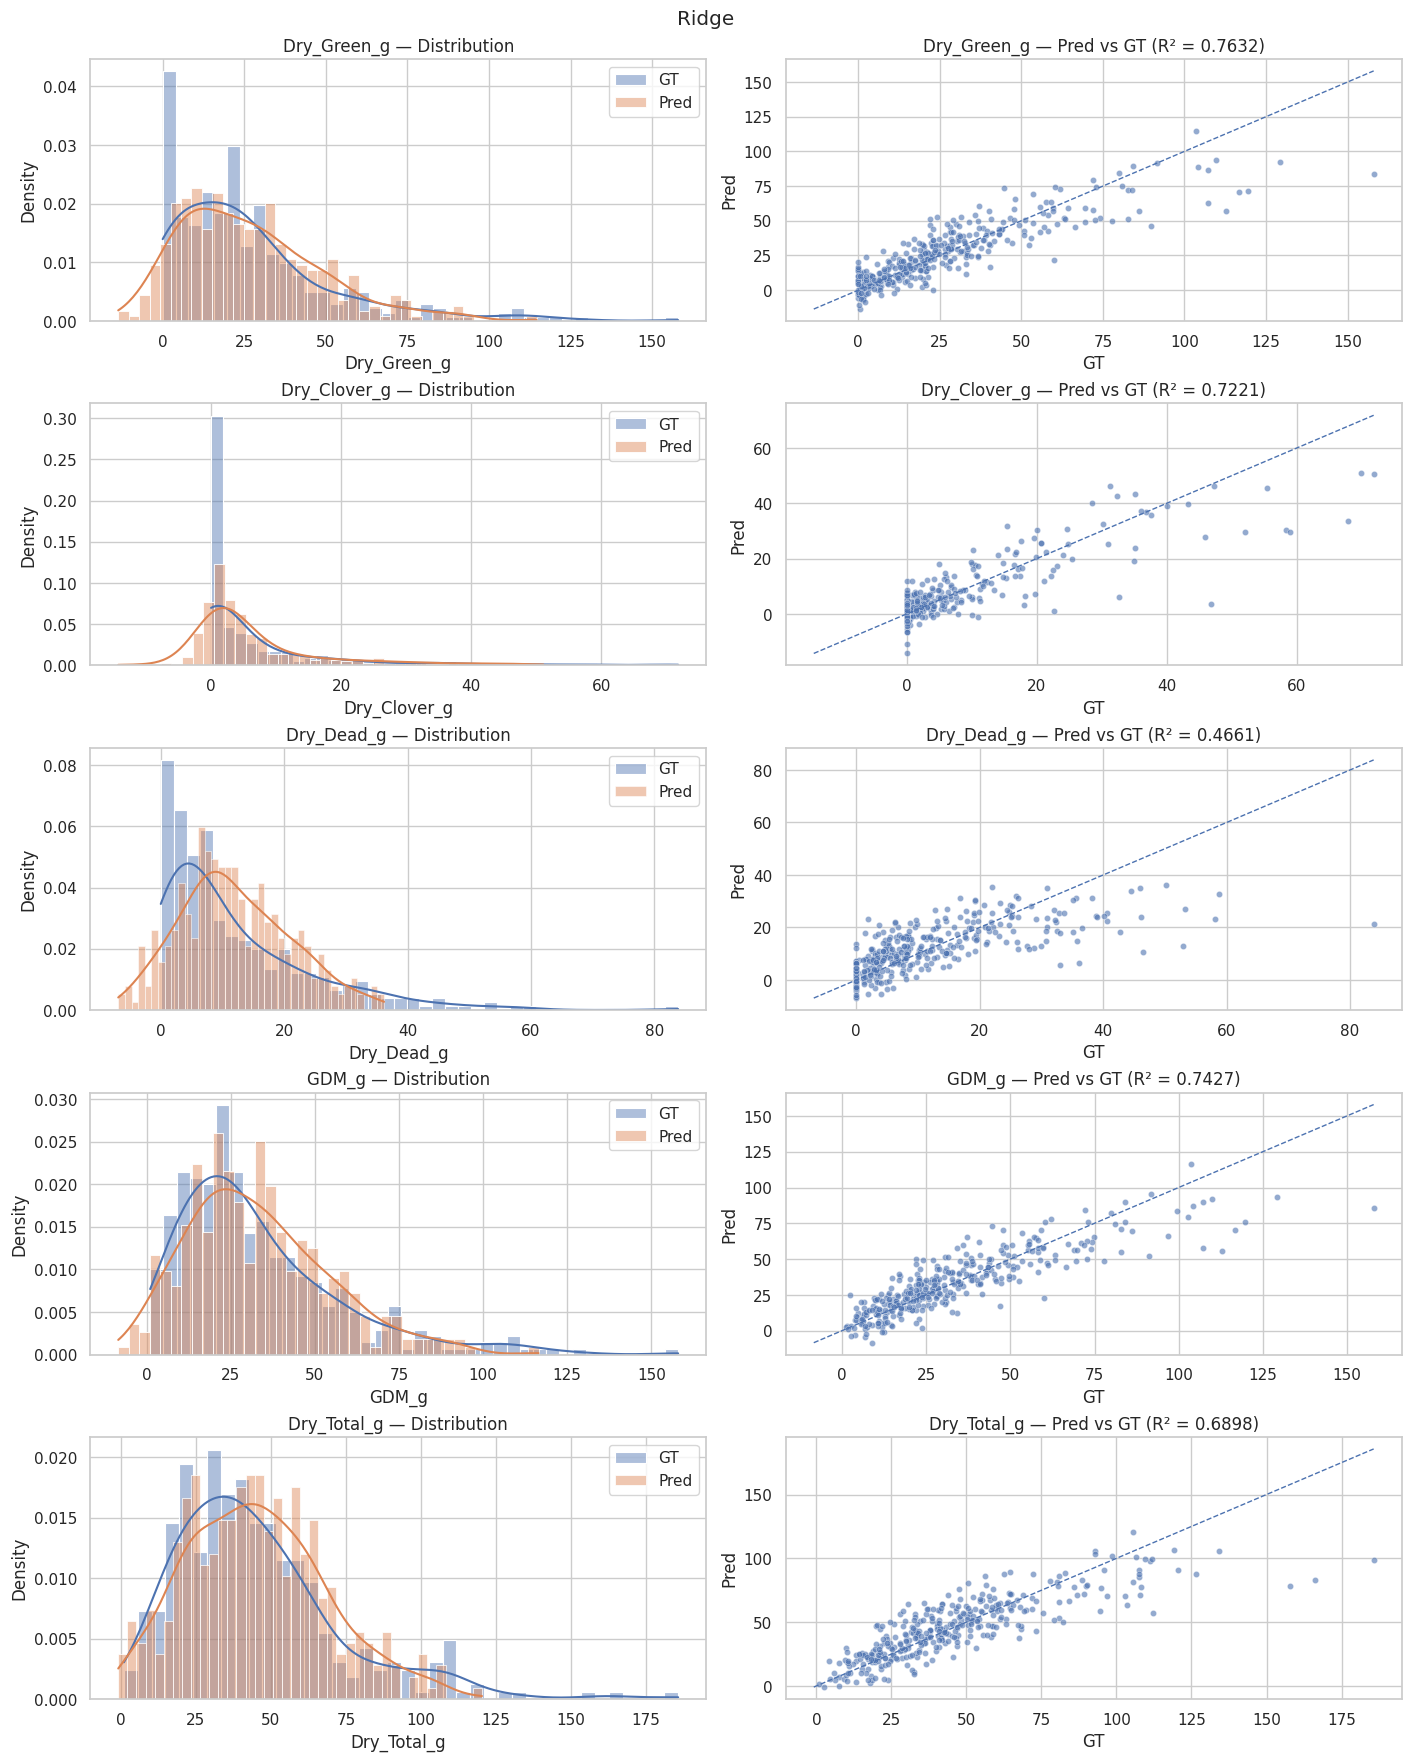

In [58]:
ridge_alphas = np.logspace(-3, 3, 13)

best_score = -np.inf
best_alpha = None
best_oof = None

for alpha in ridge_alphas:
    oof = np.zeros_like(Y, dtype=np.float32)

    pipe_tpl = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=FIXED_PCA, random_state=42)),
        ("model", Ridge(alpha=alpha))
    ])

    for tr, va in kf.split(X):
        pipe = clone(pipe_tpl)
        pipe.fit(X[tr], Y[tr])
        oof[va] = pipe.predict(X[va])

    score = weighted_r2_score(Y, oof, target_names)
    print(f"Ridge alpha={alpha:.4f} → weighted_r2={score:.5f}")

    if score > best_score:
        best_score = score
        best_alpha = alpha
        best_oof = oof.copy()
        best_pipe_tpl["Ridge"] = pipe_tpl

oof_dict["Ridge"] = best_oof
cvscore_dict["Ridge"] = best_score
best_params["Ridge"] = {"alpha": float(best_alpha)}

print("BEST Ridge:", best_params["Ridge"], "score:", best_score)

save_r2_scatter_plots(
    Y, best_oof, target_names, "Ridge"
)

### ElasticNet

ElasticNet alpha=0.001, l1=0.2 → weighted_r2=0.76912
ElasticNet alpha=0.001, l1=0.5 → weighted_r2=0.76913
ElasticNet alpha=0.001, l1=0.8 → weighted_r2=0.76913
ElasticNet alpha=0.003, l1=0.2 → weighted_r2=0.76917
ElasticNet alpha=0.003, l1=0.5 → weighted_r2=0.76917
ElasticNet alpha=0.003, l1=0.8 → weighted_r2=0.76918
BEST ElasticNet: {'alpha': 0.003, 'l1_ratio': 0.8} score: 0.7691779304067515


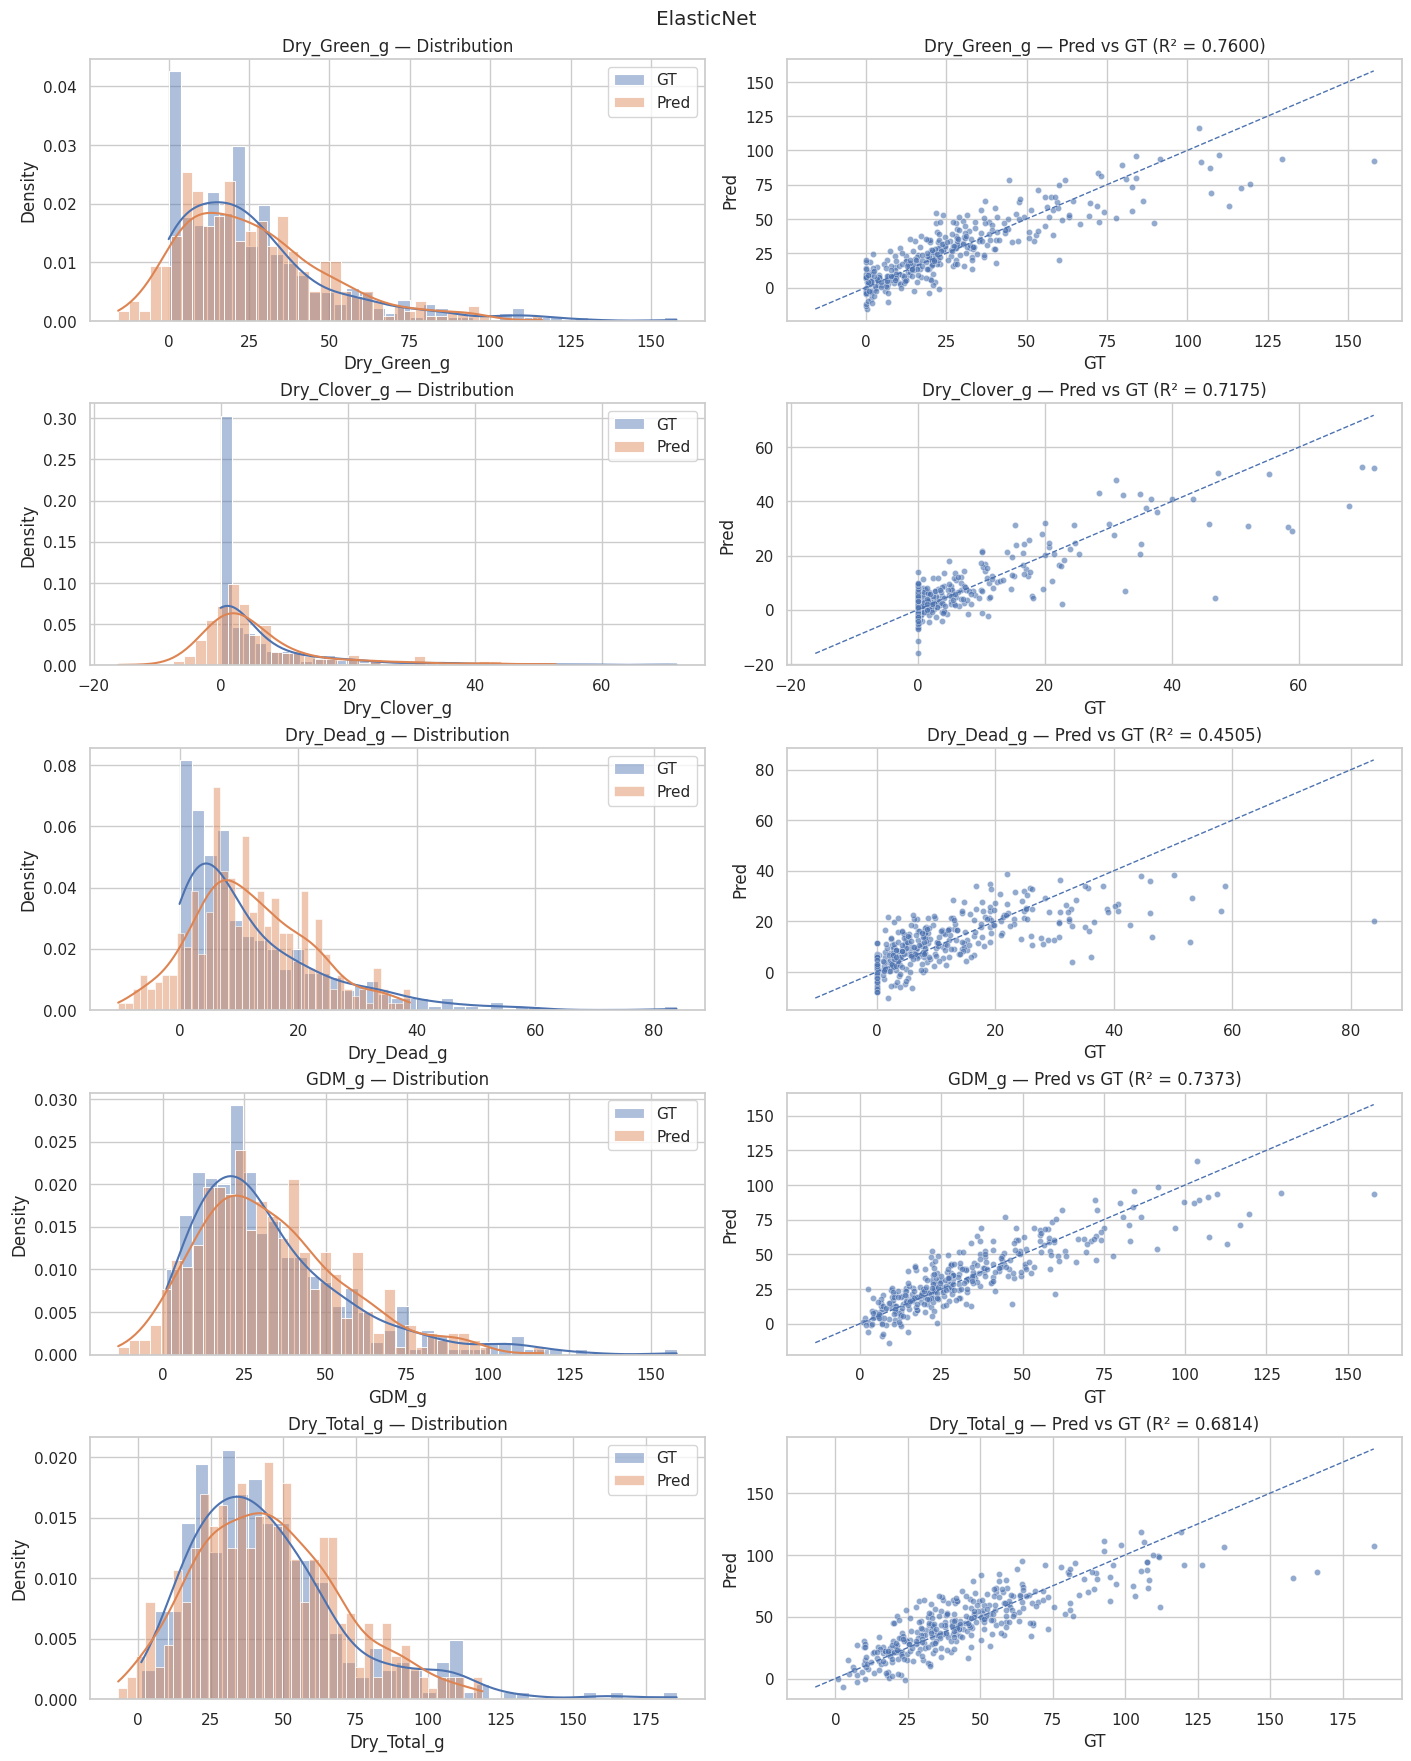

In [60]:
enet_grid = [
    (1e-3, 0.2), (1e-3, 0.5), (1e-3, 0.8),
    (3e-3, 0.2), (3e-3, 0.5), (3e-3, 0.8),
]

best_score = -np.inf
best_ab = None
best_oof = None

for alpha, l1 in enet_grid:
    oof = np.zeros_like(Y, dtype=np.float32)

    pipe_tpl = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=FIXED_PCA, random_state=42)),
        ("model", ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=50000))
    ])

    for tr, va in kf.split(X):
        pipe = clone(pipe_tpl)
        pipe.fit(X[tr], Y[tr])
        oof[va] = pipe.predict(X[va])

    score = weighted_r2_score(Y, oof, target_names)
    print(f"ElasticNet alpha={alpha}, l1={l1} → weighted_r2={score:.5f}")

    if score > best_score:
        best_score = score
        best_ab = (alpha, l1)
        best_oof = oof.copy()
        best_pipe_tpl["ElasticNet"] = pipe_tpl

oof_dict["ElasticNet"] = best_oof
cvscore_dict["ElasticNet"] = best_score
best_params["ElasticNet"] = {"alpha": float(best_ab[0]), "l1_ratio": float(best_ab[1])}

print("BEST ElasticNet:", best_params["ElasticNet"], "score:", best_score)

save_r2_scatter_plots(
    Y, best_oof, target_names, "ElasticNet"
)

### Linear Regression

LinearRegression score: 0.7691013563869948


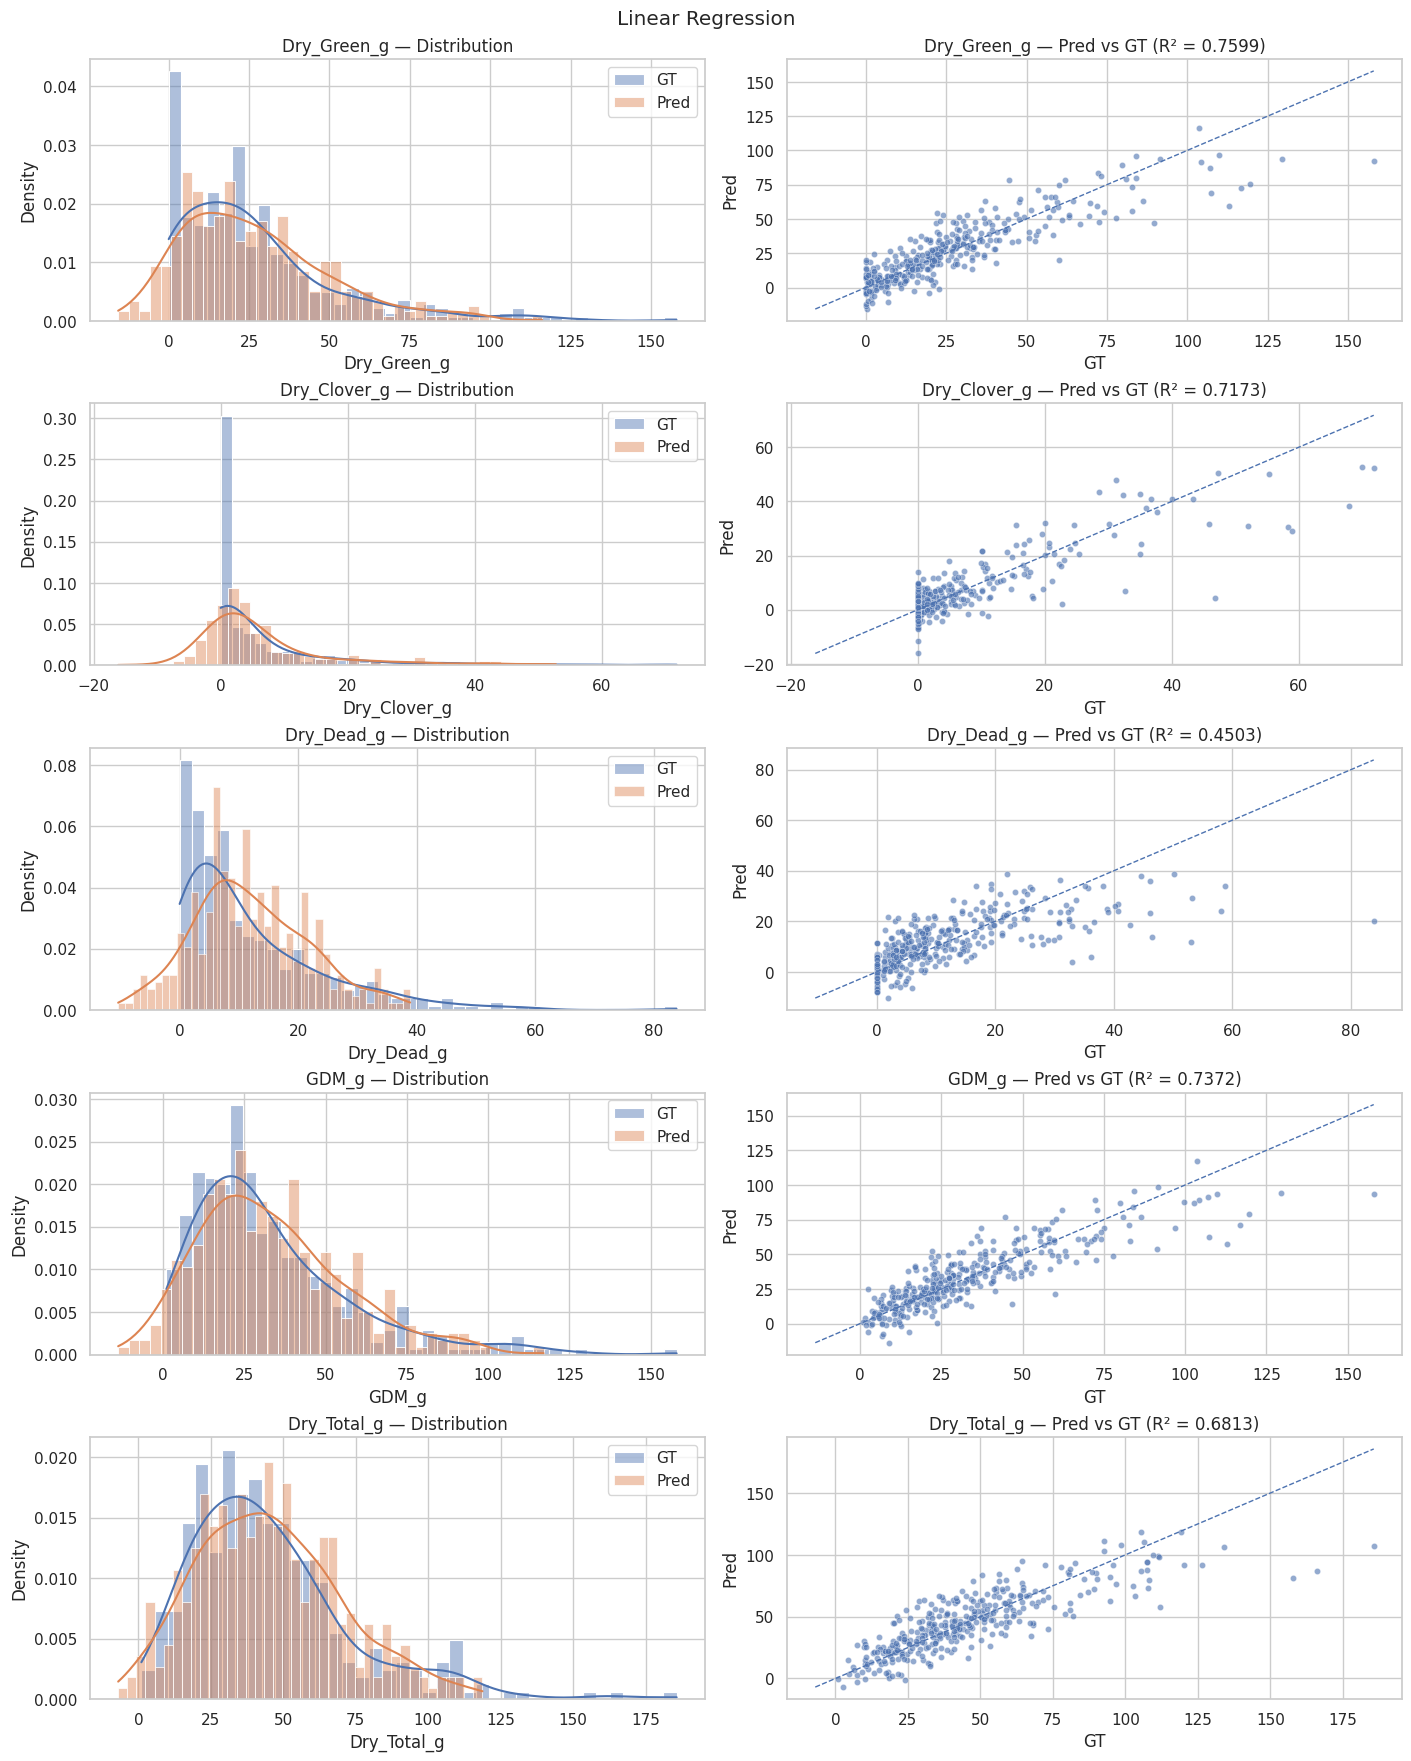

In [61]:
oof = np.zeros_like(Y, dtype=np.float32)

pipe_tpl = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=FIXED_PCA, random_state=42)),
    ("model", LinearRegression())
])

for tr, va in kf.split(X):
    pipe = clone(pipe_tpl)
    pipe.fit(X[tr], Y[tr])
    oof[va] = pipe.predict(X[va])

score = weighted_r2_score(Y, oof, target_names)

oof_dict["LinearRegression"] = oof
cvscore_dict["LinearRegression"] = score
best_pipe_tpl["LinearRegression"] = pipe_tpl
best_params["LinearRegression"] = {}

print("LinearRegression score:", score)

save_r2_scatter_plots(
    Y, oof, target_names, "Linear Regression"
)

### Equal Ensemble

Equal ensemble score: 0.7731935297254131


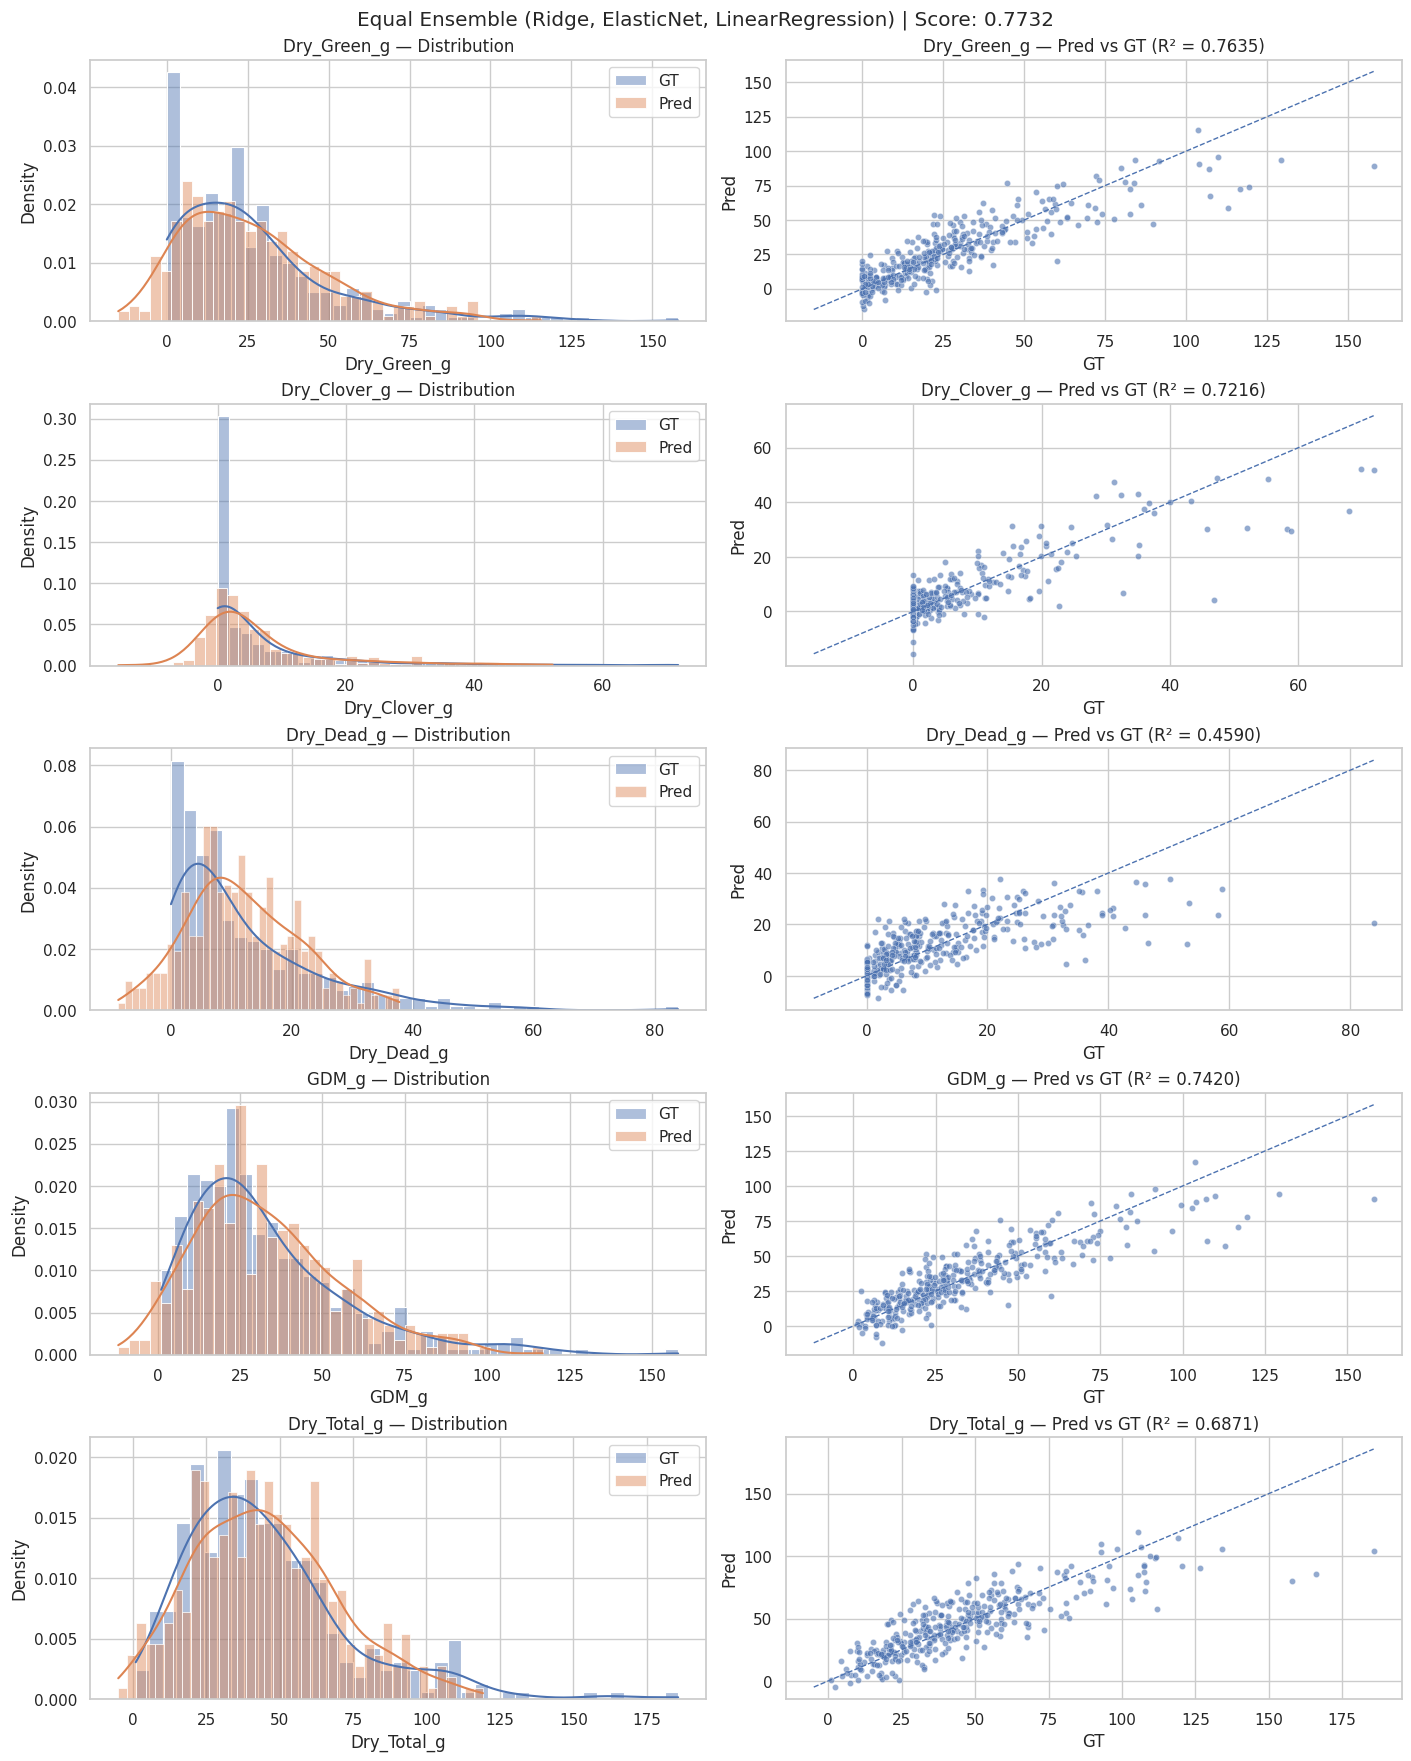

In [76]:
members = ["Ridge", "ElasticNet", "LinearRegression"]
stack = np.stack([oof_dict[m] for m in members], axis=0)   # (M,N,T)

oof_equal = stack.mean(axis=0)  # (N,T)
score_equal = weighted_r2_score(Y, oof_equal, target_names)

print("Equal ensemble score:", score_equal)
save_r2_scatter_plots(
    Y, oof_equal, target_names, f"Equal Ensemble ({', '.join(members)}) | Score: {round(score_equal, 4)}"
)

### CV score based weighted Ensemble

Weights: {'Ridge': 0.9865883190860635, 'ElasticNet': 0.013411505771888575, 'LinearRegression': 1.7514204781796988e-07}
Weighted ensemble score: 0.7747897116723748


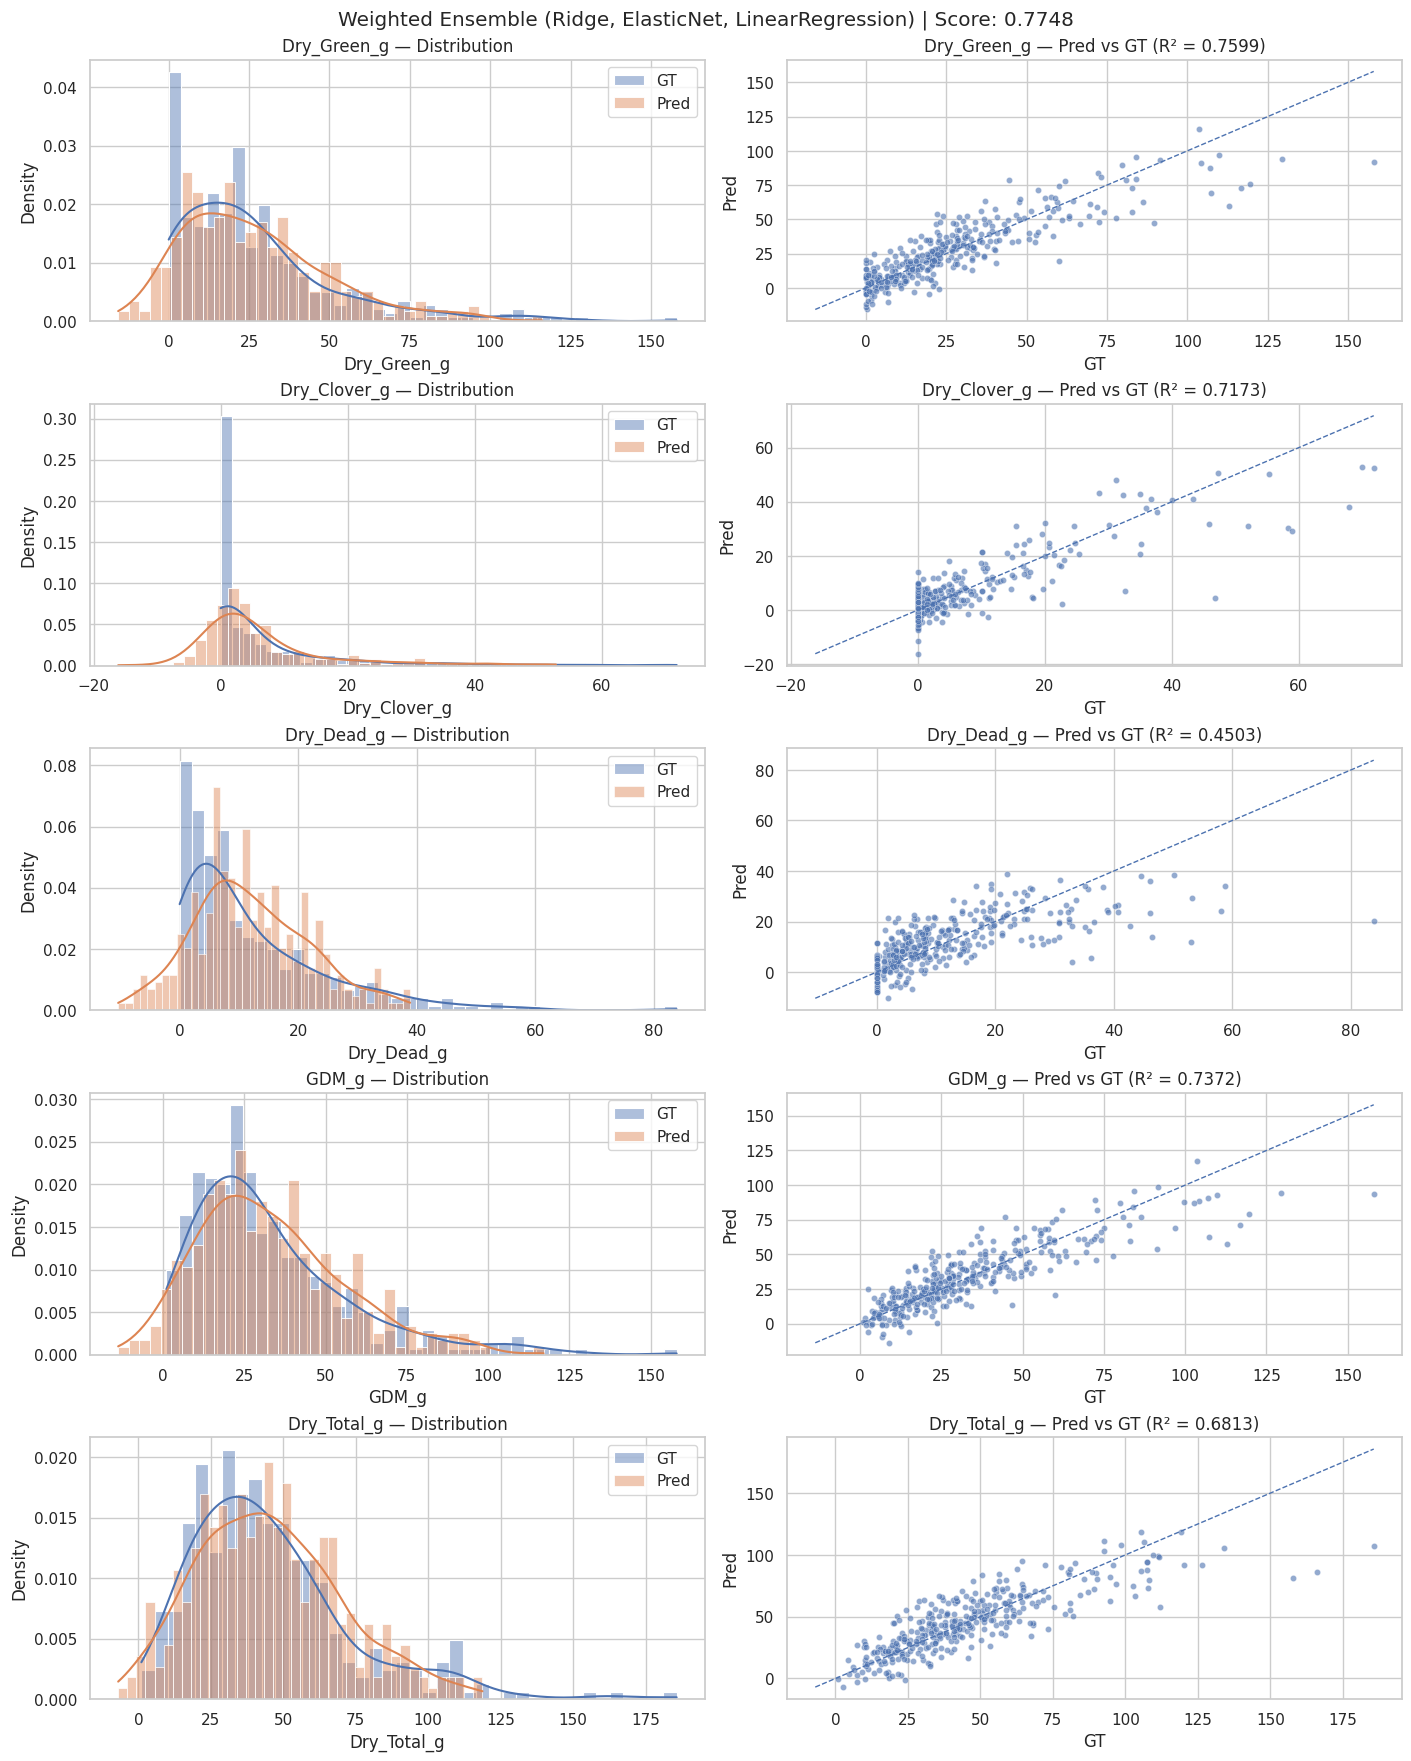

In [ ]:
scores = np.array([cvscore_dict[m] for m in members], dtype=np.float64)
w = scores - scores.min()
w = w + 1e-9
w = w / w.sum()

print(scores)
print("Weights:", {m: float(wi) for m, wi in zip(members, w)})

oof_weighted = np.zeros_like(Y, dtype=np.float32)
for wi, m in zip(w, members):
    oof_weighted += wi * oof_dict[m]

score_weighted = weighted_r2_score(Y, oof_weighted, target_names)
print("Weighted ensemble score:", score_weighted)

save_r2_scatter_plots(
    Y, oof, target_names, f"Weighted Ensemble ({', '.join(members)}) | Score: {round(score_weighted, 4)}"
)


In [67]:
print("best_params: ", best_params)
print("best_pipe_tpl: ", best_pipe_tpl)

best_params:  {'Ridge': {'alpha': 316.2277660168379}, 'ElasticNet': {'alpha': 0.003, 'l1_ratio': 0.8}, 'LinearRegression': {}}
best_pipe_tpl:  {'Ridge': Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=64, random_state=42)),
                ('model', Ridge(alpha=np.float64(316.2277660168379)))]), 'ElasticNet': Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=64, random_state=42)),
                ('model',
                 ElasticNet(alpha=0.003, l1_ratio=0.8, max_iter=50000))]), 'LinearRegression': Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=64, random_state=42)),
                ('model', LinearRegression())])}


# Saving the full pipeline

In [75]:
# output directory
out_dir = Path("../exps/classical_model_results")
out_dir.mkdir(parents=True, exist_ok=True)

fitted_models = {}

for name, pipe_tpl in best_pipe_tpl.items():
    print(f"Fitting full-data model: {name}")

    pipe = clone(pipe_tpl)     # IMPORTANT: clone template
    pipe.fit(X, Y)             # fit on full embeddings

    fitted_models[name] = pipe

    save_path = out_dir / f"{name}_pca64.joblib"
    joblib.dump(pipe, save_path)

    print(f"✅ Saved → {save_path}")

print("\nAll best classical models saved.")

ensemble_metadata = {
    "pca_components": 64,
    "models": list(best_pipe_tpl.keys()),
    "best_params": best_params,
    "ensemble_members": ["Ridge", "ElasticNet", "LinearRegression"],
    "ensemble_type": ["equal", "weighted"],
}

with open(out_dir / "ensemble_metadata.json", "w") as f:
    json.dump(ensemble_metadata, f, indent=2)

print("✅ Saved ensemble_metadata.json")


Fitting full-data model: Ridge
✅ Saved → ../exps/classical_model_results/Ridge_pca64.joblib
Fitting full-data model: ElasticNet
✅ Saved → ../exps/classical_model_results/ElasticNet_pca64.joblib
Fitting full-data model: LinearRegression
✅ Saved → ../exps/classical_model_results/LinearRegression_pca64.joblib

All best classical models saved.
✅ Saved ensemble_metadata.json


# Mass Balance results

Constraint 1 (Green+Clover-GDM) | mean abs before/after: 0.00011690124 6.963893e-07
Constraint 2 (GDM+Dead-Total)   | mean abs before/after: 0.0035620364 1.0093554e-06
Weighted ensemble score BEFORE MB: 0.7747897116723748
Weighted ensemble score AFTER  MB: 0.7747902027891778


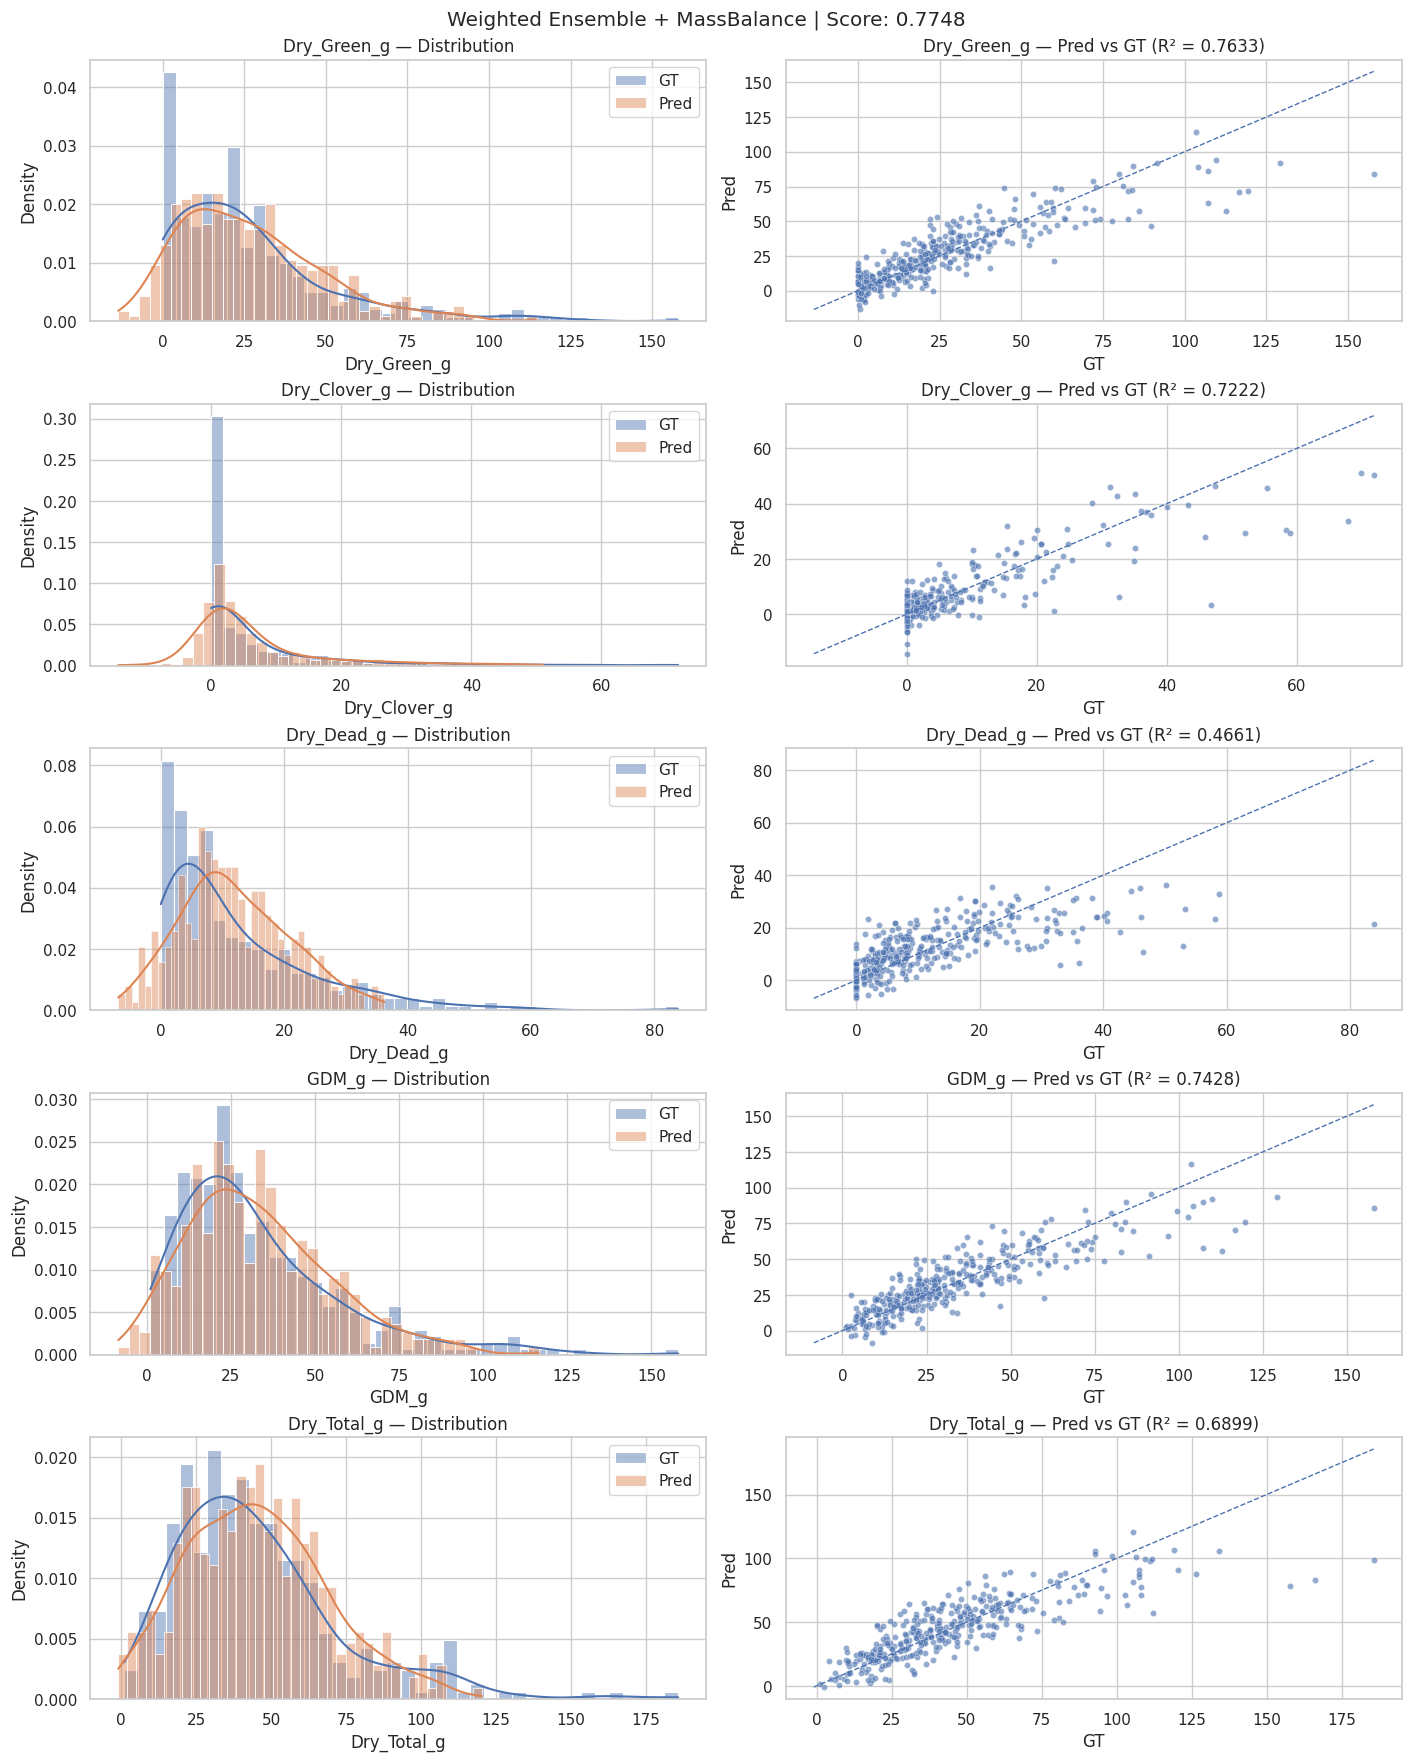

Equal ensemble score AFTER MB: 0.7731929598985069


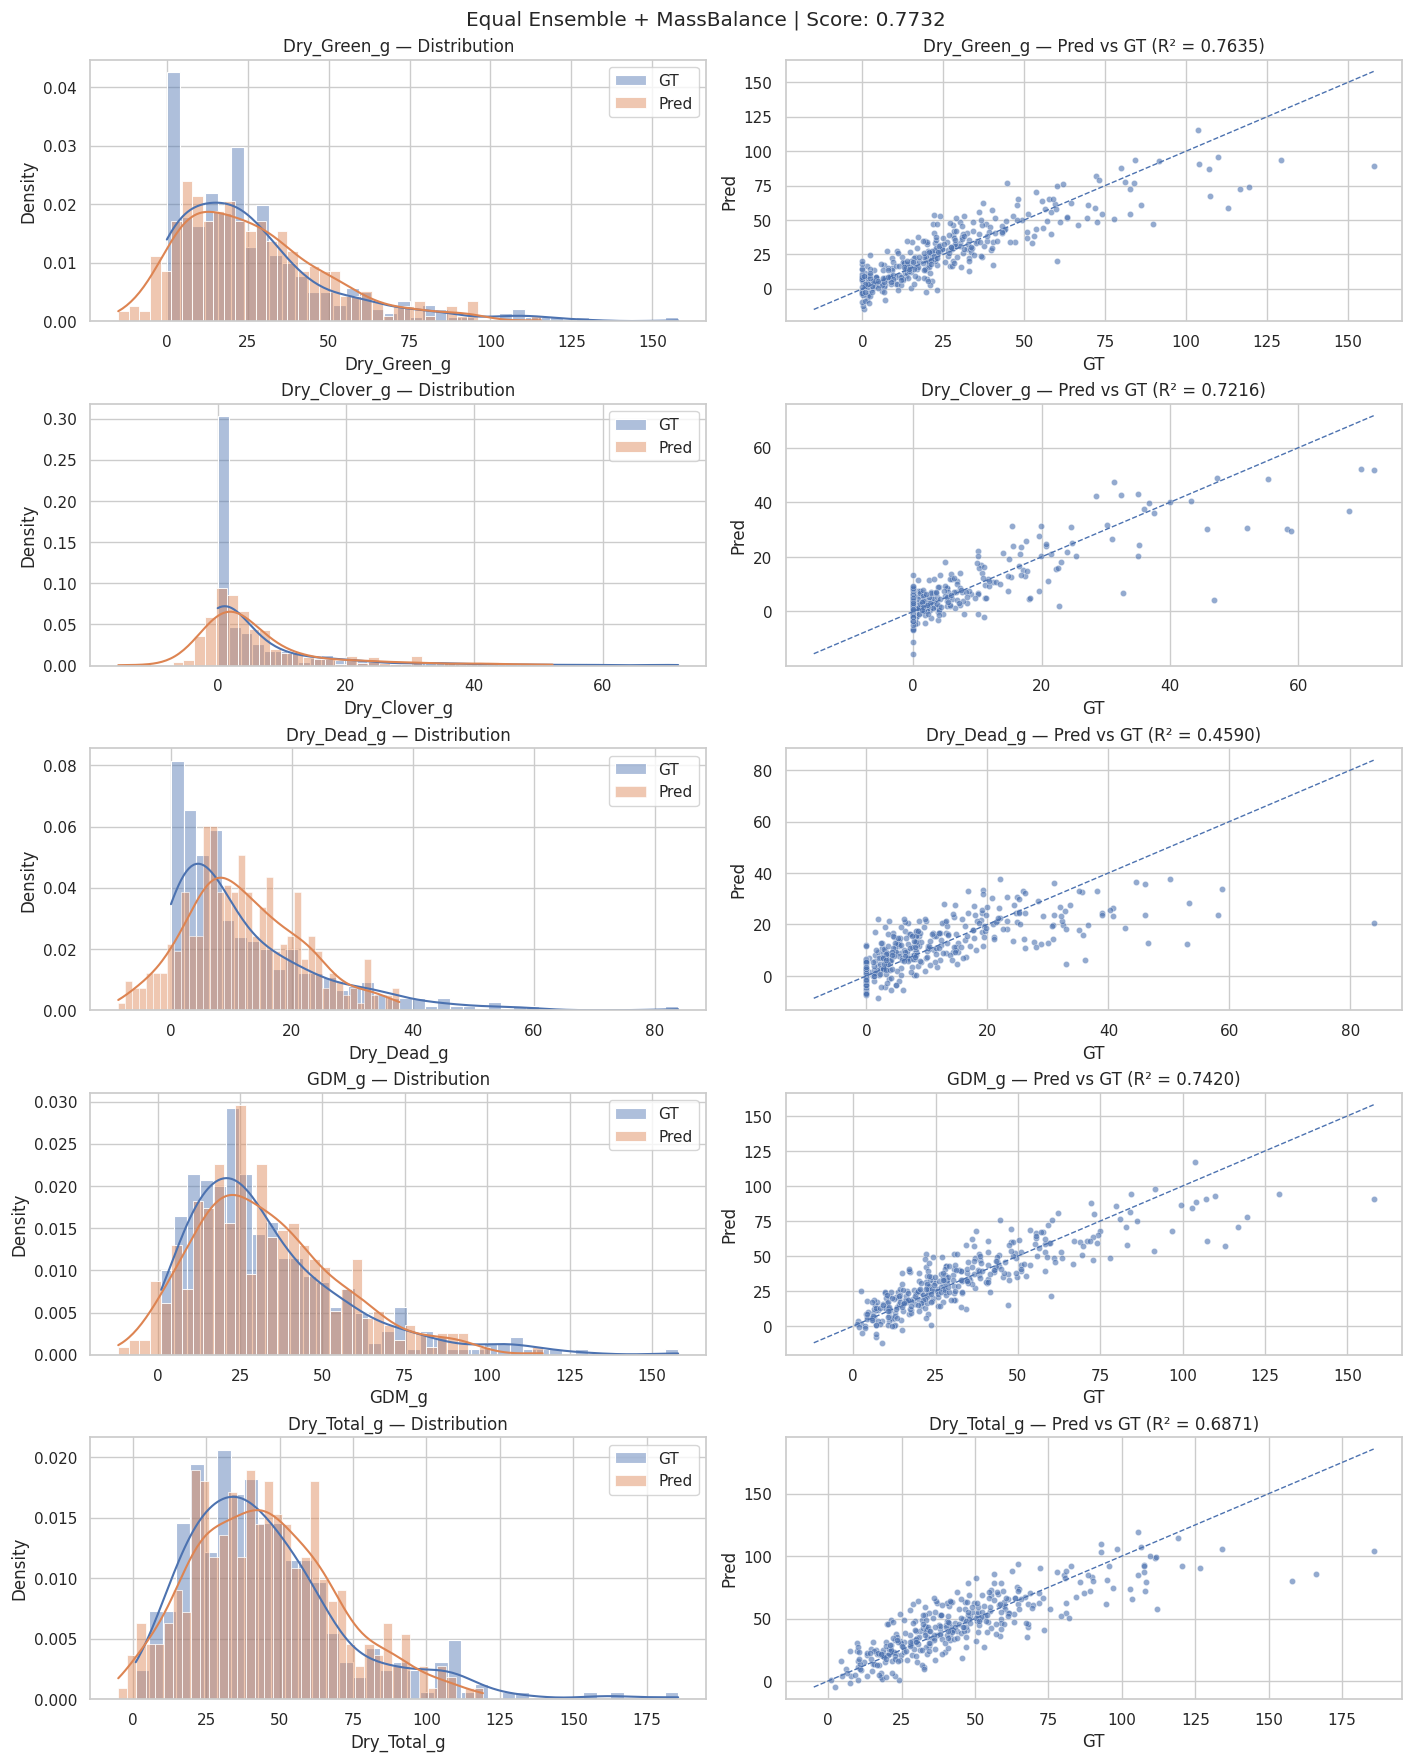

In [80]:
def enforce_mass_balance_orthogonal(
    preds: np.ndarray,
    target_names: list[str],
    clip_nonneg: bool = False,
):
    """
    Orthogonal projection onto the linear constraint set:
      1) Green + Clover - GDM = 0
      2) Dead  + GDM    - Total = 0

    preds: (N, T) where T includes the 5 required targets.
    target_names: list of column names aligned with preds columns.
    clip_nonneg: optionally clip outputs >= 0 after projection.
    """
    required = ["Dry_Green_g", "Dry_Clover_g", "Dry_Dead_g", "GDM_g", "Dry_Total_g"]
    idx = {t: target_names.index(t) for t in required}

    # Extract in fixed order: [Green, Clover, Dead, GDM, Total]
    X = np.stack([
        preds[:, idx["Dry_Green_g"]],
        preds[:, idx["Dry_Clover_g"]],
        preds[:, idx["Dry_Dead_g"]],
        preds[:, idx["GDM_g"]],
        preds[:, idx["Dry_Total_g"]],
    ], axis=1).astype(np.float64)  # (N,5)

    # Constraints A x = b (b=0)
    # [1, 1, 0,-1, 0]  -> Green + Clover - GDM = 0
    # [0, 0, 1, 1,-1]  -> Dead + GDM - Total = 0
    A = np.array([
        [1, 1, 0, -1, 0],
        [0, 0, 1,  1, -1],
    ], dtype=np.float64)  # (2,5)
    b = np.zeros((2,), dtype=np.float64)

    # Projection: x_proj = x - A^T (A A^T)^-1 (A x - b)
    AAT_inv = np.linalg.inv(A @ A.T)            # (2,2)
    resid = (X @ A.T) - b                       # (N,2)
    correction = (resid @ AAT_inv) @ A          # (N,5)
    Xp = X - correction                         # (N,5)

    if clip_nonneg:
        Xp = np.maximum(Xp, 0.0)

    # Put back into original preds array
    out = preds.astype(np.float64).copy()
    out[:, idx["Dry_Green_g"]]  = Xp[:, 0]
    out[:, idx["Dry_Clover_g"]] = Xp[:, 1]
    out[:, idx["Dry_Dead_g"]]   = Xp[:, 2]
    out[:, idx["GDM_g"]]        = Xp[:, 3]
    out[:, idx["Dry_Total_g"]]  = Xp[:, 4]

    return out.astype(np.float32)


def mass_balance_errors(preds, target_names):
    iG = target_names.index("Dry_Green_g")
    iC = target_names.index("Dry_Clover_g")
    iD = target_names.index("Dry_Dead_g")
    iGDM = target_names.index("GDM_g")
    iT = target_names.index("Dry_Total_g")

    e1 = preds[:, iG] + preds[:, iC] - preds[:, iGDM]
    e2 = preds[:, iGDM] + preds[:, iD] - preds[:, iT]
    return e1, e2


e1_before, e2_before = mass_balance_errors(oof_weighted, target_names)

oof_weighted_ens_mb = enforce_mass_balance_orthogonal(oof_weighted, target_names, clip_nonneg=False)

e1_after, e2_after = mass_balance_errors(oof_weighted_ens_mb, target_names)

print("Constraint 1 (Green+Clover-GDM) | mean abs before/after:",
      np.mean(np.abs(e1_before)), np.mean(np.abs(e1_after)))
print("Constraint 2 (GDM+Dead-Total)   | mean abs before/after:",
      np.mean(np.abs(e2_before)), np.mean(np.abs(e2_after)))


score_before = weighted_r2_score(Y, oof_weighted, target_names)
score_after  = weighted_r2_score(Y, oof_weighted_ens_mb, target_names)

print("Weighted ensemble score BEFORE MB:", score_before)
print("Weighted ensemble score AFTER  MB:", score_after)

save_r2_scatter_plots(
    Y, oof_weighted_ens_mb, target_names,
    model_name=f"Weighted Ensemble + MassBalance | Score: {score_after:.4f}"
)


oof_equal_ens_mb = enforce_mass_balance_orthogonal(oof_equal, target_names, clip_nonneg=False)
score_equal_after = weighted_r2_score(Y, oof_equal_ens_mb, target_names)

print("Equal ensemble score AFTER MB:", score_equal_after)

save_r2_scatter_plots(
    Y, oof_equal_ens_mb, target_names,
    model_name=f"Equal Ensemble + MassBalance | Score: {score_equal_after:.4f}"
)



# Saving embedding model

In [81]:
from pathlib import Path
import json
import torch
import timm

SAVE_DIR = Path("../exps/classical_model_results/embedding_model")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

MODEL_ID = "vit_huge_plus_patch16_dinov3.lvd1689m"

# 1) create + download weights once
model = timm.create_model(MODEL_ID, pretrained=True, num_classes=0)
model.eval()

# 2) save weights
weights_path = SAVE_DIR / f"{MODEL_ID}.pt"
torch.save(model.state_dict(), weights_path)

# 3) save minimal metadata so you can recreate the model offline
meta = {
    "model_id": MODEL_ID,
    "num_classes": 0,
}
meta_path = SAVE_DIR / f"{MODEL_ID}.json"
meta_path.write_text(json.dumps(meta, indent=2))

print("✅ Saved:", weights_path)
print("✅ Saved:", meta_path)


✅ Saved: ../exps/classical_model_results/embedding_model/vit_huge_plus_patch16_dinov3.lvd1689m.pt
✅ Saved: ../exps/classical_model_results/embedding_model/vit_huge_plus_patch16_dinov3.lvd1689m.json
